In [111]:
import pandas as pd
import numpy as np
# import scipy as sp
# from datetime import datetime
from dateutil import parser
import datetime
from matplotlib import pyplot as plt
import os.path
import pickle
from scipy.stats import expon
from collections import defaultdict
from collections import Counter
import math

### Clusters of interest  
E-128 nodes, IDs: 9,10,11  
F-256 nodes, IDs: 14,15,16,17

In [112]:
E_IDs = [9, 10, 11]
F_IDs = [14,15,16,17]

system_dict = {
    1 : 'A',
    2 : 'B',
    3 : 'C',
    4 : 'D',
    5 : 'E',
    6 : 'E',
    7 : 'E',
    8 : 'E',
    9 : 'E',
    10 : 'E',
    11 : 'E',
    12 : 'E',
    13 : 'F',
    14 : 'F',
    15 : 'F',
    16 : 'F',
    17 : 'F',
    18 : 'F',
    19 : 'G',
    20 : 'G',
    21 : 'G',
    22 : 'H'
}

In [113]:
# Read LANL data
lanl = pd.read_csv("data/LANL.csv")
lanl.head()

,System,machine type,nodes,procstot,procsinnode,nodenum,nodenumz,node install,node prod,node decom,...,Prob Started (mm/dd/yy hh:mm),Prob Fixed (mm/dd/yy hh:mm),Down Time,Facilities,Hardware,Human Error,Network,Undetermined,Software,Same Event
0,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,6/21/2005 10:54,6/21/2005 11:00,6,NaN,Graphics Accel Hdwr,NaN,NaN,NaN,NaN,No
1,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 9:13,9/6/2005 9:19,6,NaN,NaN,NaN,NaN,NaN,Other Software,No
2,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 10:32,9/6/2005 10:46,14,NaN,NaN,NaN,NaN,Undetermined,NaN,No
3,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 14:50,9/6/2005 15:08,18,NaN,NaN,NaN,NaN,NaN,Other Software,No
4,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/8/2005 16:52,9/8/2005 16:57,5,NaN,NaN,NaN,NaN,Undetermined,NaN,No


In [114]:
lanl.describe()

,System,nodes,procstot,procsinnode,nodenum,nodenumz,mem,cputype,memtype,num intercon,Down Time
count,23739.000000,23613.000000,23613.000000,23613.000000,23613.000000,23613.000000,23613.00000,23613.000000,23613.000000,23613.000000,23739.000000
mean,12.316020,412.039809,3637.940118,58.041672,328.775590,186.204506,27.35599,2.036929,2.036929,5.117732,352.381440
std,7.728558,434.469638,2069.976059,61.866268,534.668188,274.941531,54.55763,1.721330,1.721330,4.591858,4683.012911
min,2.000000,1.000000,4.000000,2.000000,0.000000,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,49.000000,2048.000000,4.000000,9.000000,8.000000,8.00000,1.000000,1.000000,2.000000,25.000000
50%,16.000000,128.000000,4096.000000,4.000000,40.000000,37.000000,16.00000,2.000000,2.000000,2.000000,59.000000
75%,19.000000,1024.000000,6152.000000,128.000000,384.000000,241.000000,32.00000,2.000000,2.000000,12.000000,144.000000
max,24.000000,1024.000000,6152.000000,256.000000,2047.000000,1023.000000,1024.00000,8.000000,8.000000,12.000000,319482.000000


In [115]:
# Drop useless columns
for col in lanl:
    if len(lanl[col].unique()) == 1:
        print("Dropping: ", str(col))
        del lanl[col]
        

Dropping:  Same Event


In [116]:
# look at the different possibilities in each column
for col in lanl:
    print(col, ": ", lanl[col].unique())

System :  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
machine type :  ['cluster' 'smp' 'numa' nan]
nodes :  [4.900e+01 1.280e+02 3.200e+01 1.000e+00 1.640e+02 2.560e+02 5.120e+02
 1.600e+01       nan 1.024e+03 5.000e+00]
procstot :  [6.152e+03 5.120e+02 1.280e+02 8.000e+00 3.280e+02 1.024e+03 2.560e+02
 2.048e+03       nan 4.096e+03 4.000e+00 5.440e+02 3.200e+01]
procsinnode :  [ 80. 128.   4.   8.   2. 256.  nan  32.]
nodenum :  [  0.   1.   2. ... 436. 442. 447.]
nodenumz :  [0.00e+00 1.00e+00 2.00e+00 ... 9.94e+02 1.00e+03 1.02e+03]
node install :  ['5-Apr' 'Nov-96' '3-Aug' 'before tracking' '1-Mar' '2-Dec' '5-Mar'
 '4-Nov' 'Oct-96' nan '2-Mar' '2-Aug' '1-Oct' '1-Aug' 'Jan-98' 'Oct-98'
 '2-Nov']
node prod :  ['5-Jun' 'Jan-97' '3-Sep' 'before tracking' '1-Apr' '2-Dec' '5-Mar'
 '4-Nov' 'Dec-96' nan '2-May' '2-Oct' '1-Dec' '1-Sep' 'Jan-98' 'Oct-98'
 '2-Nov']
node decom :  ['current' '5-Nov' 'Dec-99' '5-Jun' '2-Sep' nan '2-Jan' '3-Apr' '4-Dec'
 '3-Dec']
fru ty

In [117]:
# Time objects and time sorting
date_sort = lanl
# change to datetime objects
date_sort["Prob Started (mm/dd/yy hh:mm)"] = pd.to_datetime(date_sort["Prob Started (mm/dd/yy hh:mm)"])
date_sort["Prob Fixed (mm/dd/yy hh:mm)"] = pd.to_datetime(date_sort["Prob Fixed (mm/dd/yy hh:mm)"])

# sort
date_sort = date_sort.sort_values("Prob Started (mm/dd/yy hh:mm)")

# get first and last time
first_issue = date_sort["Prob Started (mm/dd/yy hh:mm)"].iloc[0]
last_issue = date_sort["Prob Fixed (mm/dd/yy hh:mm)"].iloc[-1]

print("First Time: ", first_issue)
print("Last Time: ", last_issue)
time_difference = last_issue - first_issue
interval_size = int(time_difference.total_seconds()/60)
print("Minutes: ", interval_size)
date_sort.head()

First Time:  1995-05-19 21:55:00
Last Time:  2005-09-09 13:47:00
Minutes:  5422552


,System,machine type,nodes,procstot,procsinnode,nodenum,nodenumz,node install,node prod,node decom,...,purpose,Prob Started (mm/dd/yy hh:mm),Prob Fixed (mm/dd/yy hh:mm),Down Time,Facilities,Hardware,Human Error,Network,Undetermined,Software
8071,7,smp,1.0,8.0,8.0,0.0,0.0,before tracking,before tracking,Dec-99,...,compute,1995-05-19 21:55:00,1995-05-19 22:58:00,63,NaN,NaN,NaN,NaN,NaN,NaN
8072,7,smp,1.0,8.0,8.0,0.0,0.0,before tracking,before tracking,Dec-99,...,compute,1995-05-21 08:21:00,1995-05-21 11:00:00,159,NaN,NaN,NaN,NaN,NaN,NaN
8073,7,smp,1.0,8.0,8.0,0.0,0.0,before tracking,before tracking,Dec-99,...,compute,1995-05-21 11:00:00,1995-05-21 18:35:00,455,NaN,NaN,NaN,NaN,NaN,DST
8074,7,smp,1.0,8.0,8.0,0.0,0.0,before tracking,before tracking,Dec-99,...,compute,1995-05-23 13:15:00,1995-05-23 14:15:00,60,NaN,NaN,NaN,NaN,Unresolvable,NaN
8075,7,smp,1.0,8.0,8.0,0.0,0.0,before tracking,before tracking,Dec-99,...,compute,1995-06-06 07:00:00,1995-06-06 07:35:00,35,NaN,NaN,NaN,NaN,NaN,DST


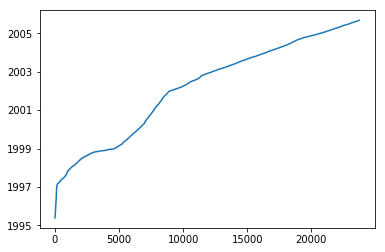

In [11]:
# Verify in correct time order, strictly increasing
plt.figure()
plt.plot(range(0,len(date_sort)), date_sort["Prob Started (mm/dd/yy hh:mm)"])
plt.show()

In [12]:
# fig, ax = plt.subplots()
# ax.plot(r.date, r.adj_close)

# # format the ticks
# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# # round to nearest years...
# datemin = np.datetime64(r.date[0], 'Y')
# datemax = np.datetime64(r.date[-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

In [80]:
# setup lists to graph by Minute
graph_data = defaultdict(list)
for system in date_sort.System.unique():
    for i in range(0,interval_size):
        graph_data[system].append(0)

# check for stored result        
all_graphs_file = "graph_times"
if os.path.isfile(all_graphs_file):
    with open(all_graphs_file, "rb") as f:
        graph_data = pickle.load(f)
else:
    # for every system plot the number of nodes down as a function of time
    for system in date_sort.System.unique():
        temp_df = date_sort[date_sort.System == system]
        temp_df.sort_values("Prob Started (mm/dd/yy hh:mm)")
        issue_start_time = temp_df["Prob Started (mm/dd/yy hh:mm)"].iloc[0]
        issue_end_time = temp_df["Prob Started (mm/dd/yy hh:mm)"].iloc[-1]
        i = int((issue_start_time-first_issue).total_seconds()/60)
        while i < (issue_end_time-first_issue).total_seconds()/60:
            graph_data[system][i] += 1
            i += 1
            
# Save results            
with open(all_graphs_file, "wb") as f:
    pickle.dump(graph_data, f)

# try plotting by using a histogram
# issue_start_times = [(parser.parse(a)-first_issue).total_seconds()/60 for a in date_sort["Prob Started (mm/dd/yy hh:mm)"]]
# issue_end_times = [(parser.parse(a)-first_issue).total_seconds()/60 for a in date_sort["Prob Fixed (mm/dd/yy hh:mm)"]]

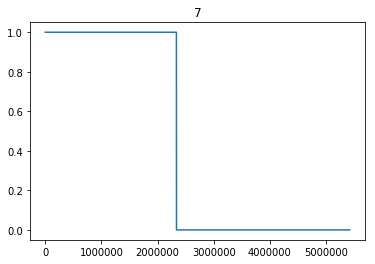

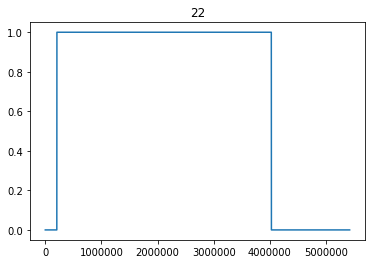

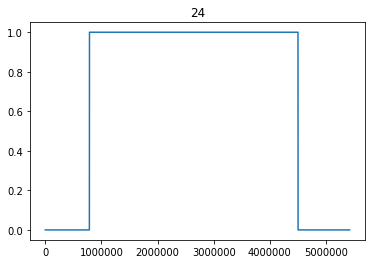

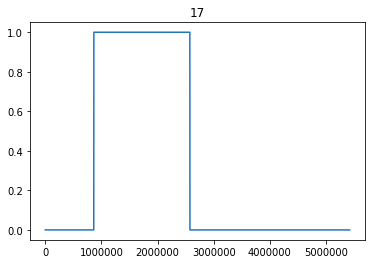

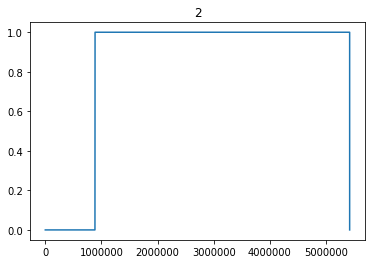

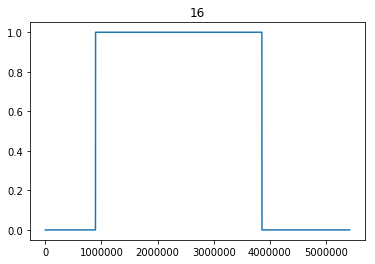

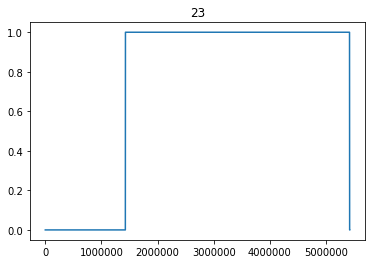

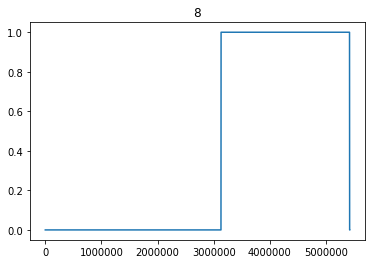

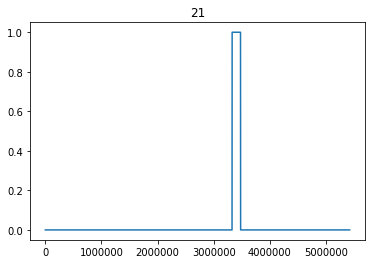

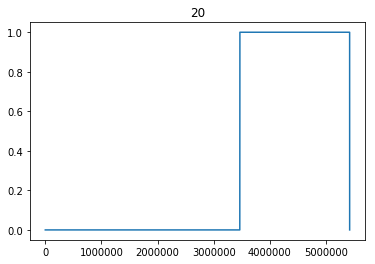

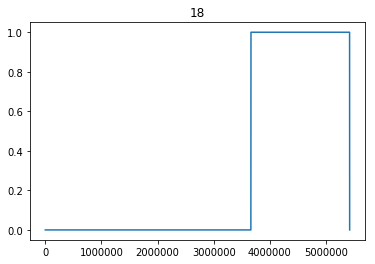

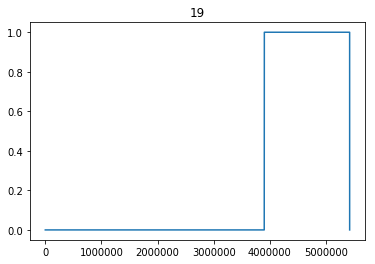

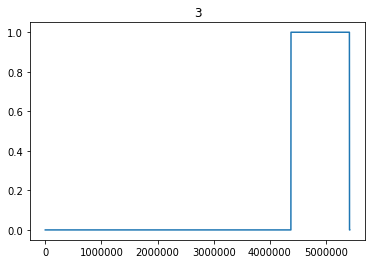

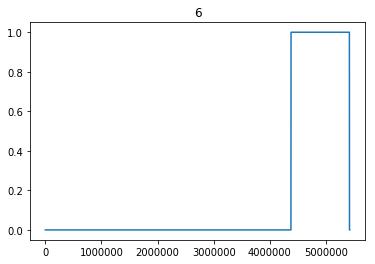

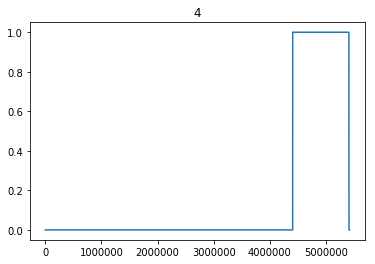

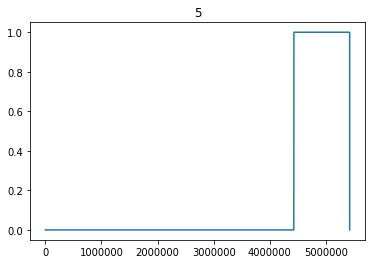

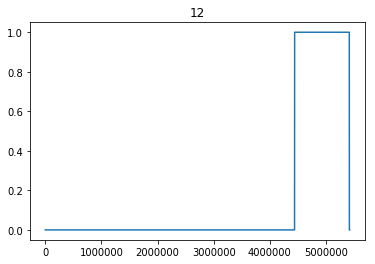

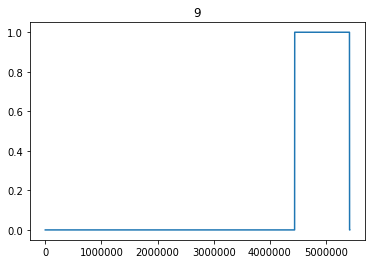

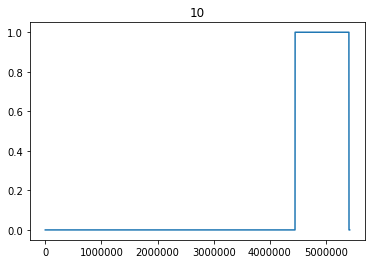

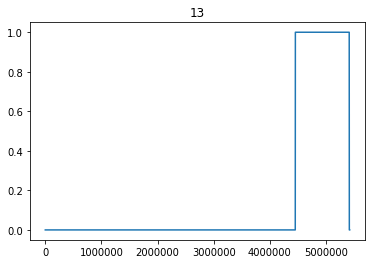

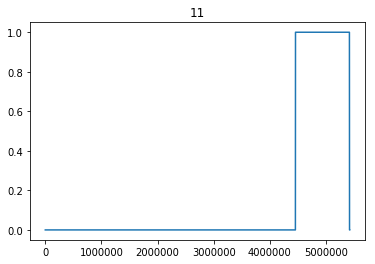

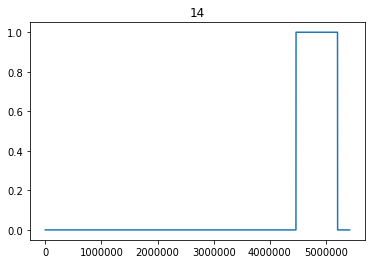

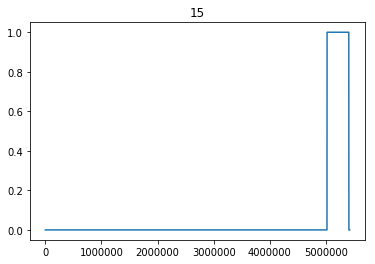

In [81]:
# graph the lists
for key in graph_data:
    fig, ax = plt.subplots()
    ax.plot(range(0,interval_size), graph_data[key])
    ax.set_title(key)
    plt.show()
# fig, ax = plt.subplots()
# ax.plot(range(0,interval_size), graph_data[9])
# plt.show()

Threshold:  469.8419197663479
Outliers:  1599  ~ 0.06735751295336788 %


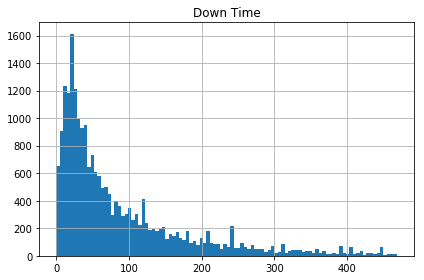

In [15]:
# Plot Down Times
plt.close('all')
# fig, ax = plt.subplots()

down_time_mean = date_sort["Down Time"].mean()
down_time_std = date_sort["Down Time"].std()
down_time_count = date_sort["Down Time"].count()
threshold = down_time_mean+down_time_mean/3#+(down_time_std*1/1000)
# threshold = 100
outliers = len(date_sort.loc[date_sort["Down Time"] > threshold])
print("Threshold: ", threshold)
print("Outliers: ", outliers, " ~", (outliers/down_time_count), "%")

down_time_clean = date_sort[date_sort["Down Time"] <= threshold]
down_time_clean.hist(column="Down Time", bins=100)

plt.tight_layout()
plt.show()

Human Error 138


<Figure size 432x288 with 0 Axes>

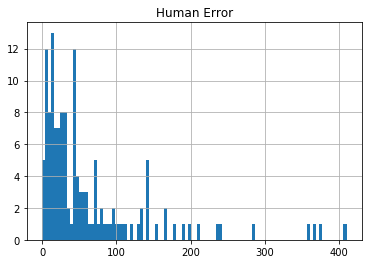

Software 5084


<Figure size 432x288 with 0 Axes>

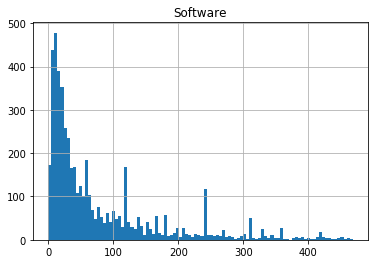

Undetermined 2448


<Figure size 432x288 with 0 Axes>

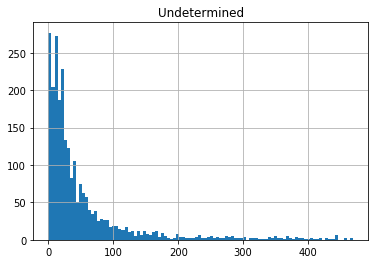

Network 377


<Figure size 432x288 with 0 Axes>

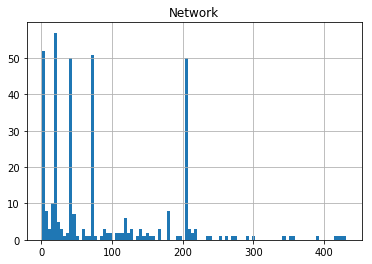

Hardware 13441


<Figure size 432x288 with 0 Axes>

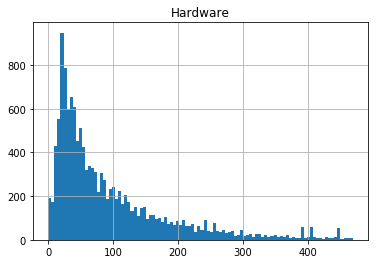

In [82]:
# errors by type
# Network, Software, Undetermined, Human Error
down_types = ["Human Error", "Software", "Undetermined", "Network", "Hardware"]
for i in down_types:
    type_hist = down_time_clean[[i, "Down Time"]].dropna()
    plt.figure()
    type_hist.hist(["Down Time"], bins=100)
    plt.title(i)
    print(i, len(type_hist))
    plt.show()
    
# human_error = date_sort.loc[date_sort["Human Error"] != "nan"]
# software = date_sort.loc[date_sort["Software"] != "nan"]
# undetermined = date_sort.loc[date_sort["Undetermined"] != "nan"]
# network = date_sort.loc[date_sort["Network"] != "nan"]


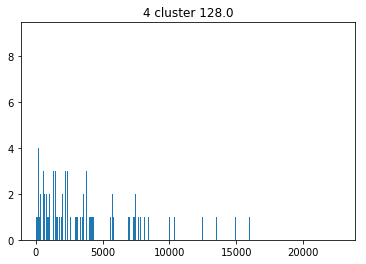

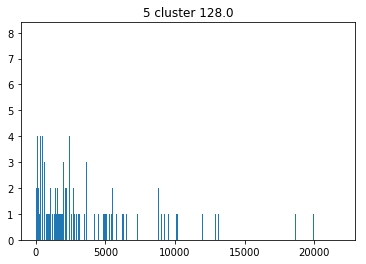

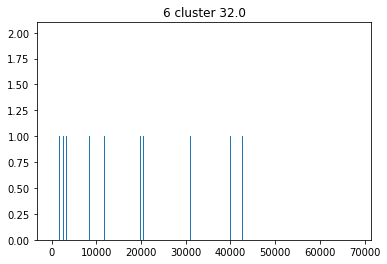

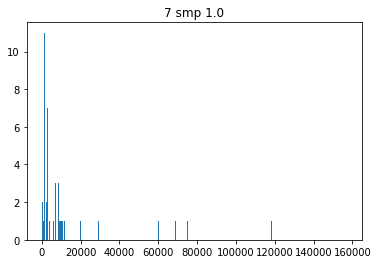

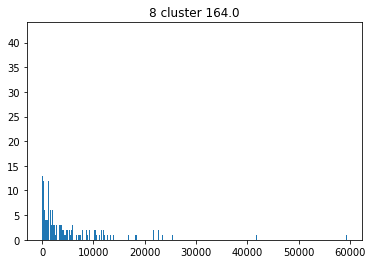

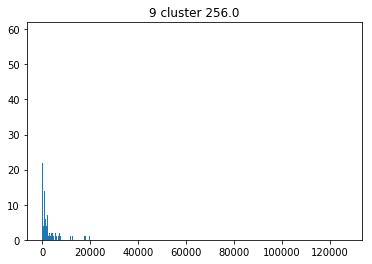

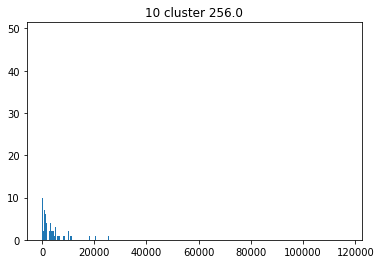

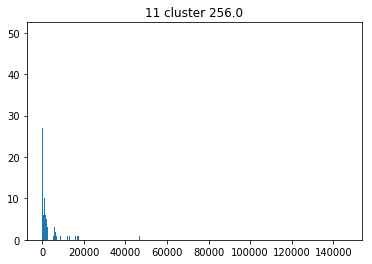

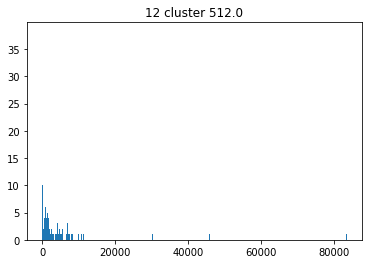

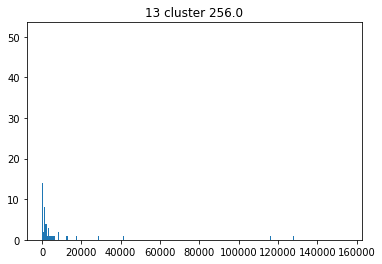

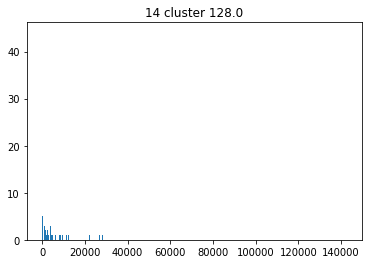

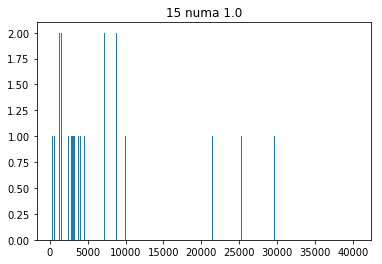

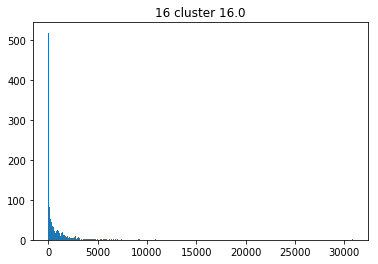

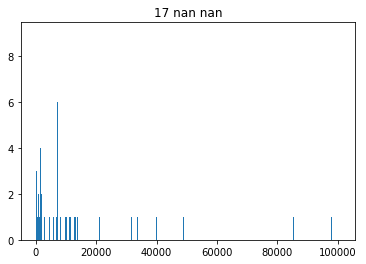

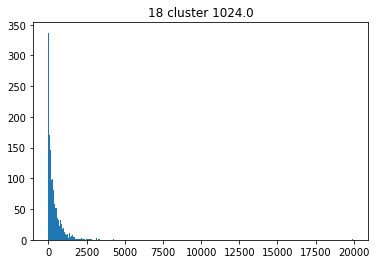

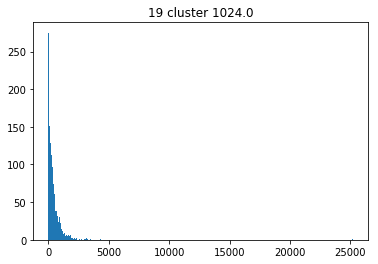

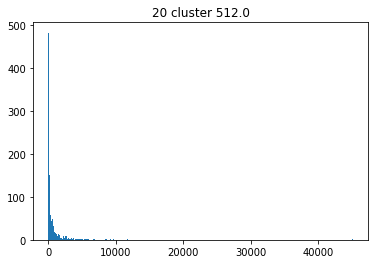

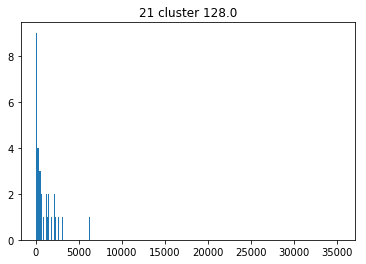

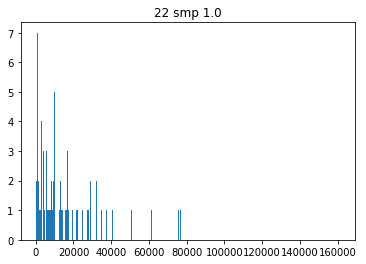

In [17]:
# from scipy.optimize import curve_fit
f = lambda x, l : 1 - np.exp(-l*x)

# for i in date_sort.System.unique():
for i in range(4,23):
    # get start times
    system_info = date_sort[date_sort.System == i]
#     first_issue = parser.parse(system_info["Prob Started (mm/dd/yy hh:mm)"].iloc[0])
    interarrival = system_info["Prob Started (mm/dd/yy hh:mm)"].diff()
    interarrival = [a.total_seconds()/60 for a in interarrival][1:]
#     interarrival = [a for a in interarrival if a < 1000]
    
    plt.figure()
    plt.hist(interarrival, bins=1000)
    plt.title(str(i)+" "+str(system_info["machine type"].iloc[0])+" "+str(system_info["nodes"].iloc[0]))
    plt.show()
    
#     interarrival.sort()
#     interarrival_cdf = [interarrival.count(b) for b in interarrival]
#     interarrival_cdf = interarrival_cdf.unique()
#     print(interarrival.unique(), interarrival_cdf)
    
#     aloc, ascale = expon.fit(interarrival)
# #     cache_param, cache_diag = optimize.curve_fit(f, issue_start_times, cache.cdf)
    
#     # Plot Web data against its approximated exponential
#     fig, ax = plt.subplots(linewidth=2)

#     cdf_approx = expon.cdf(interarrival, loc=aloc, scale=ascale)

# #     ax.semilogx(interarrival, web.cdf, color="r", label="Web") # get cdf of interarrival times
#     ax.plot(interarrival, cdf_approx, "--", color="black", label="approx")
# #     ax.semilogx(interarrival, cdf_approx, "--", color="black", label="approx")

# #     plt.xlim(web.duration[1],500)
#     plt.xlabel("Interarrival Duration (minutes)")
#     plt.ylabel("CDF")

#     plt.legend(loc=4)

#     ax.get_xaxis().set_visible(True)
#     ax.get_yaxis().set_visible(True)
#     ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
#     ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
#     ax.set_facecolor('white')

#     fig.set_size_inches(6, 3.5)
#     plt.show()
    
    
    

['0', '1', '2', '3', '4', '5', '6']


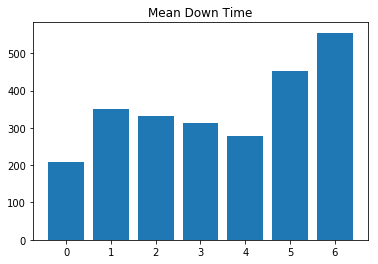

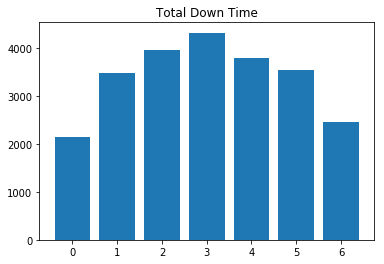

In [18]:
down_time = defaultdict(int)
down_number = defaultdict(int)

for index, row in date_sort.iterrows():
    down_time[row["Prob Started (mm/dd/yy hh:mm)"].strftime("%w")] += row["Down Time"]
    down_number[row["Prob Started (mm/dd/yy hh:mm)"].strftime("%w")] += 1

a = list(down_time.keys())
a.sort()
print(a)

b = []
number_down = []
total_down = []
for key in a:
    b.append(down_time[key]/down_number[key])
    number_down.append(down_number[key])
    total_down.append(down_number[key])
    
plt.figure()
plt.bar(a,b)
plt.title("Mean Down Time")
plt.show()

plt.figure()
plt.bar(a,total_down)
plt.title("Total Down Time")
plt.show()

# plt.figure()
# plt.bar(a,number_down)
# plt.title("Number Down")
# plt.show()

['0', '1', '2', '3', '4', '5', '6']


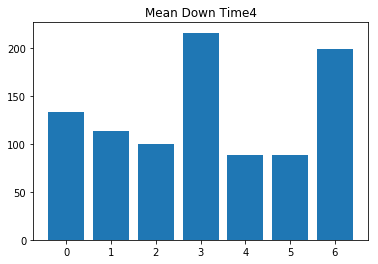

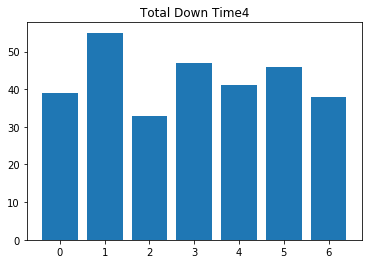

['0', '1', '2', '3', '4', '5', '6']


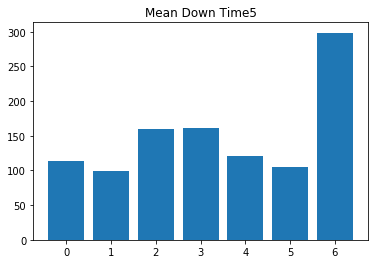

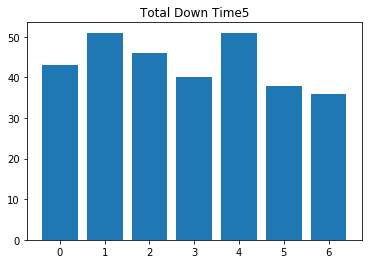

['0', '1', '2', '3', '4', '5', '6']


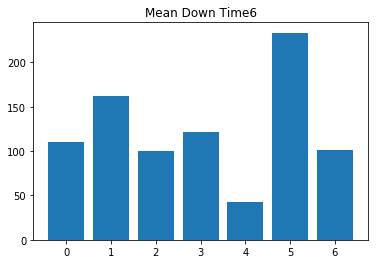

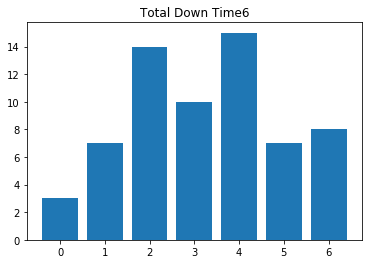

['0', '1', '2', '3', '4', '5', '6']


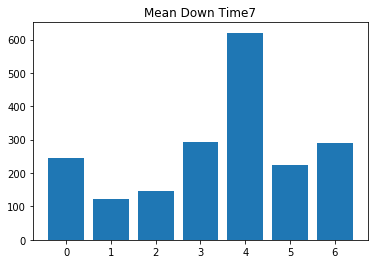

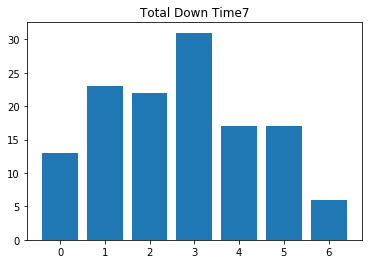

['0', '1', '2', '3', '4', '5', '6']


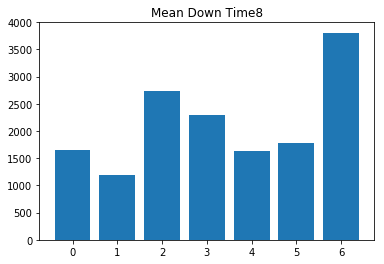

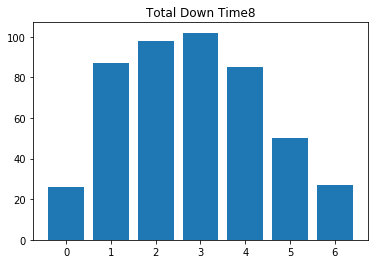

['0', '1', '2', '3', '4', '5', '6']


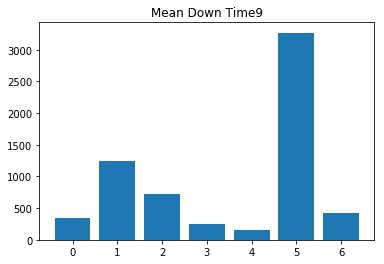

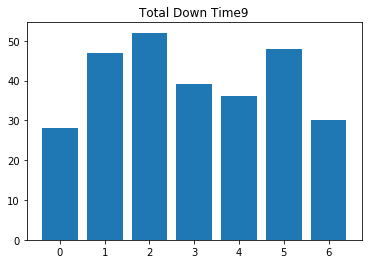

['0', '1', '2', '3', '4', '5', '6']


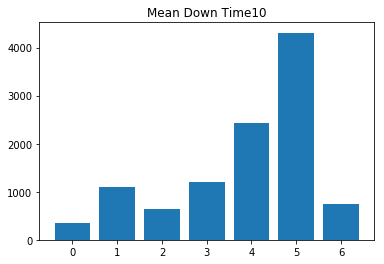

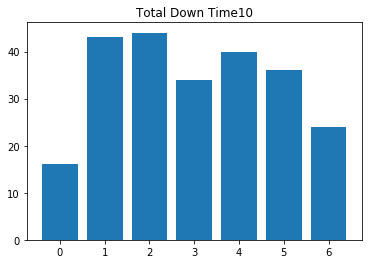

['0', '1', '2', '3', '4', '5', '6']


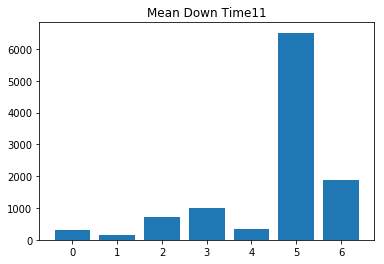

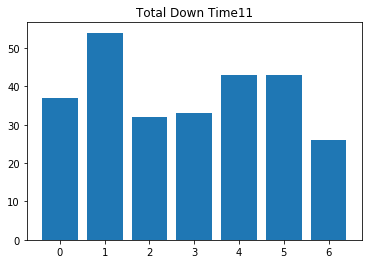

['0', '1', '2', '3', '4', '5', '6']


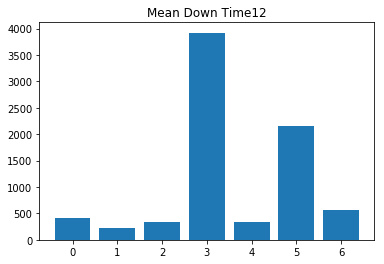

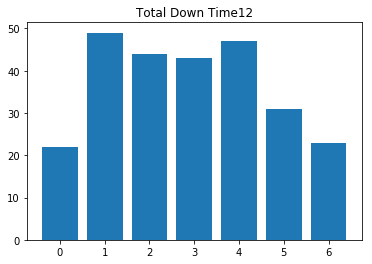

['0', '1', '2', '3', '4', '5', '6']


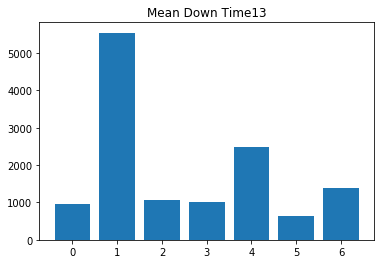

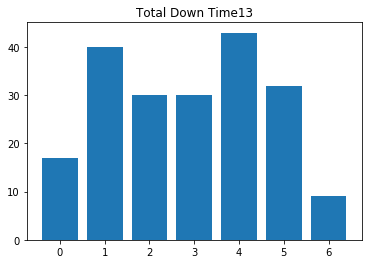

['0', '1', '2', '3', '4', '5', '6']


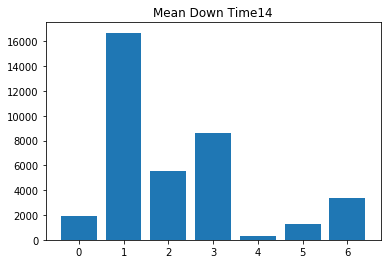

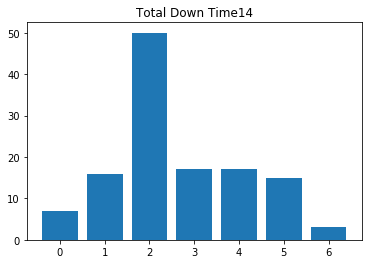

['0', '1', '2', '3', '4', '5', '6']


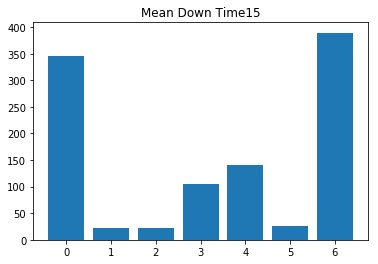

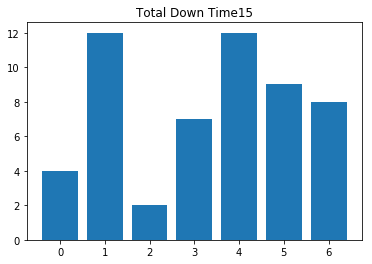

['0', '1', '2', '3', '4', '5', '6']


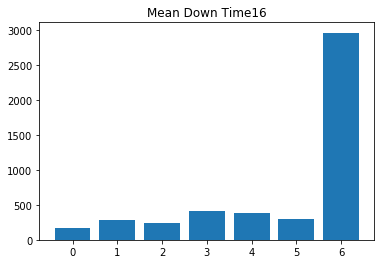

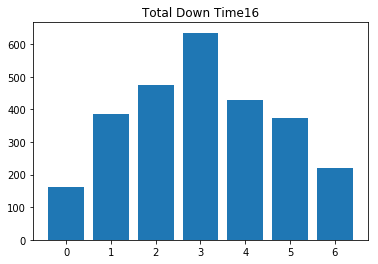

['0', '1', '2', '3', '4', '5', '6']


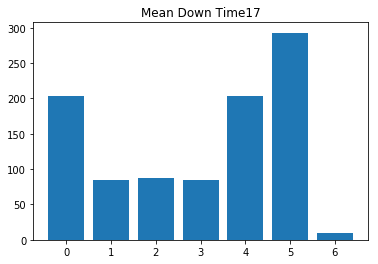

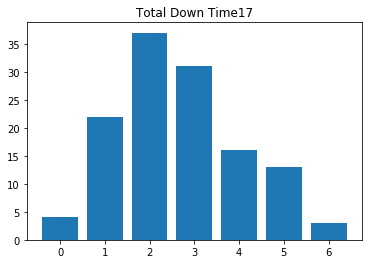

['0', '1', '2', '3', '4', '5', '6']


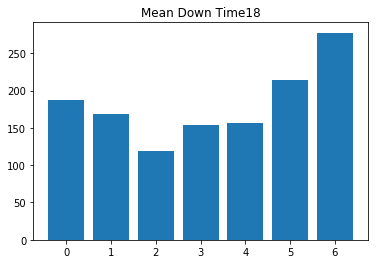

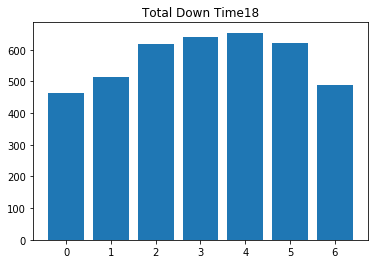

['0', '1', '2', '3', '4', '5', '6']


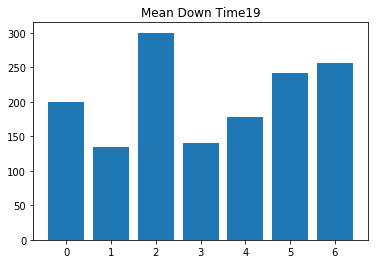

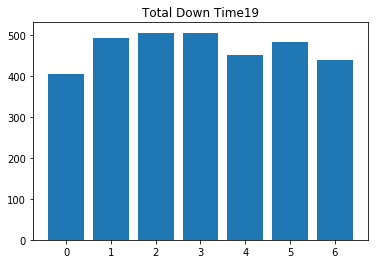

['0', '1', '2', '3', '4', '5', '6']


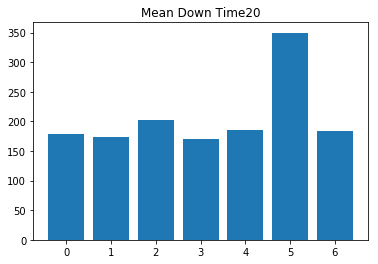

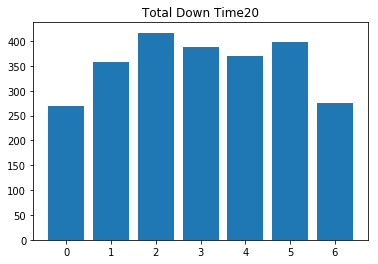

['0', '1', '2', '3', '4', '5', '6']


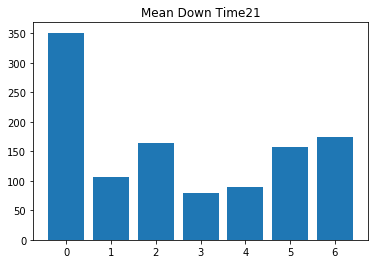

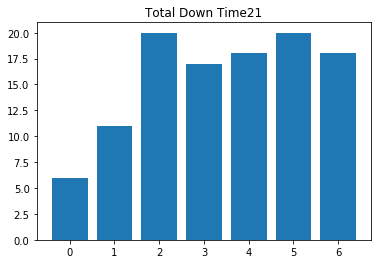

['0', '1', '2', '3', '4', '5', '6']


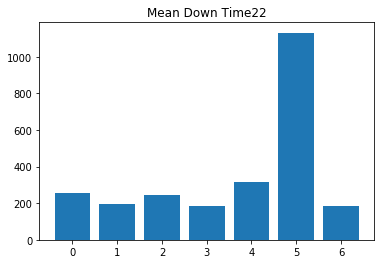

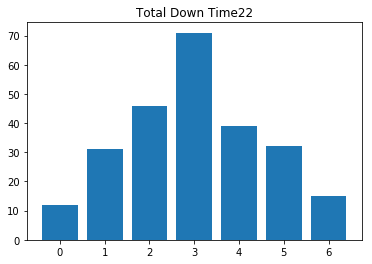

In [83]:
# Break up Down time by System
for i in range(4,23):
    down_time = defaultdict(int)
    down_number = defaultdict(int)

    for index, row in date_sort[date_sort.System == i].iterrows():
        down_time[row["Prob Started (mm/dd/yy hh:mm)"].strftime("%w")] += row["Down Time"]
        down_number[row["Prob Started (mm/dd/yy hh:mm)"].strftime("%w")] += 1

    a = list(down_time.keys())
    a.sort()
    print(a)

    b = []
    number_down = []
    total_down = []
    for key in a:
        b.append(down_time[key]/down_number[key])
        number_down.append(down_number[key])
        total_down.append(down_number[key])

    plt.figure()
    plt.bar(a,b)
    plt.title("Mean Down Time"+str(i))
    plt.show()

    plt.figure()
    plt.bar(a,total_down)
    plt.title("Total Down Time"+str(i))
    plt.show()

#     plt.figure()
#     plt.bar(a,number_down)
#     plt.title("Number Down"+str(i))
#     plt.show()

['0', '1', '2', '3', '4', '5', '6']


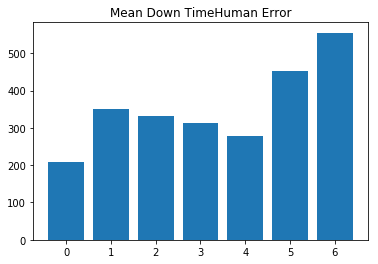

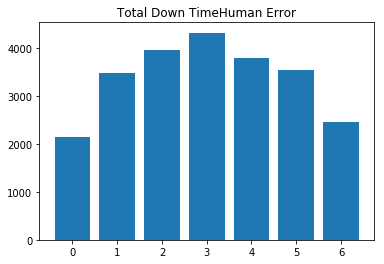

['0', '1', '2', '3', '4', '5', '6']


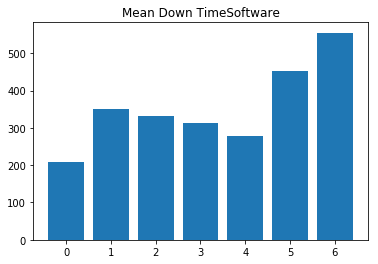

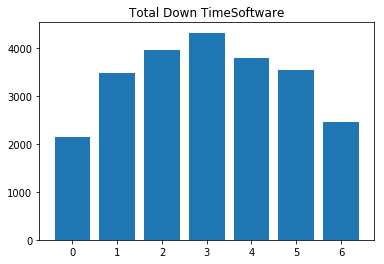

['0', '1', '2', '3', '4', '5', '6']


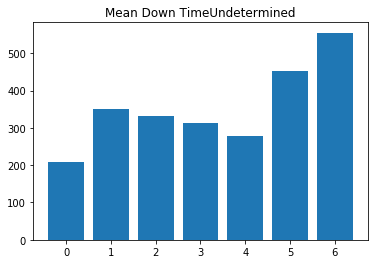

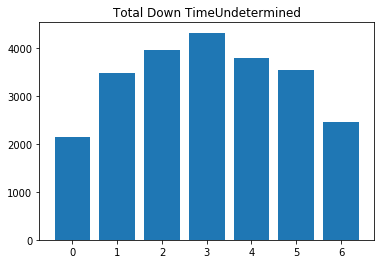

['0', '1', '2', '3', '4', '5', '6']


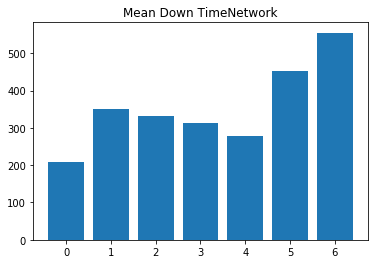

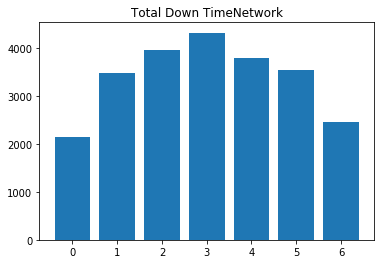

['0', '1', '2', '3', '4', '5', '6']


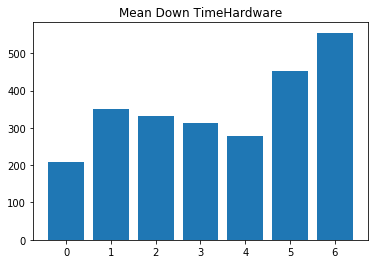

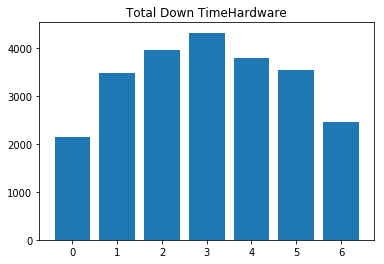

In [84]:
# Break up Down time by outage type
down_types = ["Human Error", "Software", "Undetermined", "Network", "Hardware"]
for i in down_types:
    down_time = defaultdict(int)
    down_number = defaultdict(int)
    temp_df = date_sort[[i,"Prob Started (mm/dd/yy hh:mm)"]].dropna()
    for index, row in date_sort.iterrows():
        down_time[row["Prob Started (mm/dd/yy hh:mm)"].strftime("%w")] += row["Down Time"]
        down_number[row["Prob Started (mm/dd/yy hh:mm)"].strftime("%w")] += 1

    a = list(down_time.keys())
    a.sort()
    print(a)

    b = []
    number_down = []
    total_down = []
    for key in a:
        b.append(down_time[key]/down_number[key])
        number_down.append(down_number[key])
        total_down.append(down_number[key])

    plt.figure()
    plt.bar(a,b)
    plt.title("Mean Down Time"+str(i))
    plt.show()

    plt.figure()
    plt.bar(a,total_down)
    plt.title("Total Down Time"+str(i))
    plt.show()

#     plt.figure()
#     plt.bar(a,number_down)
#     plt.title("Number Down"+str(i))
#     plt.show()

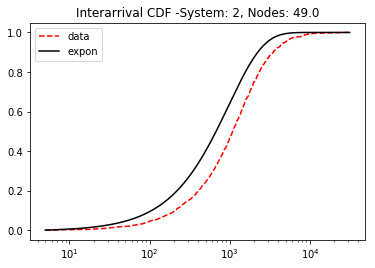

Lambda:  0.0010353469067917193 Loc:  4.999999999993438
2499


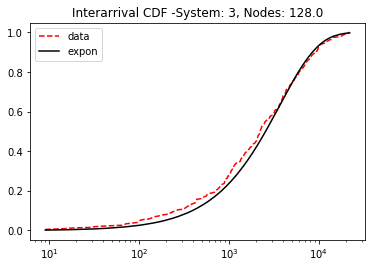

Lambda:  0.0002717040507636807 Loc:  8.999999999997838
16


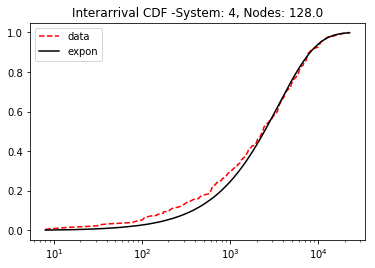

Lambda:  0.0002828407482438291 Loc:  7.999999998425687
16


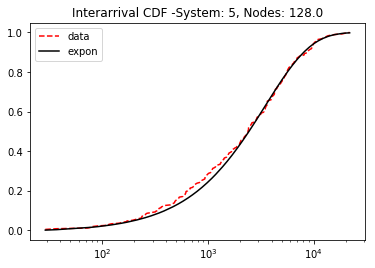

Lambda:  0.0002869174890134778 Loc:  28.999999999999456
22


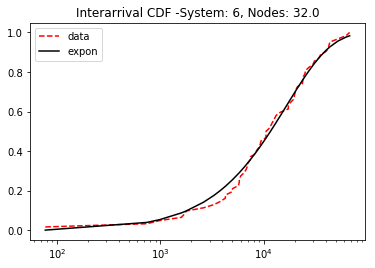

Lambda:  5.980976742995403e-05 Loc:  76.9999999998796
1


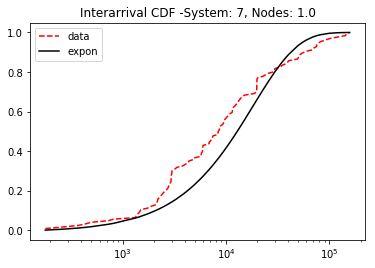

Lambda:  5.465863792491559e-05 Loc:  178.99999999997277
2


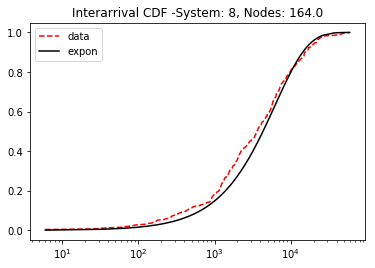

Lambda:  0.00016046813596817683 Loc:  5.999999999968388
136


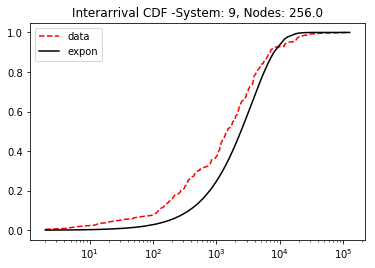

Lambda:  0.0002839441447837804 Loc:  1.9999999851104886
38


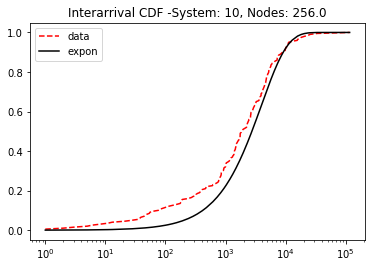

Lambda:  0.00025207808250127744 Loc:  0.9999999999987133
36


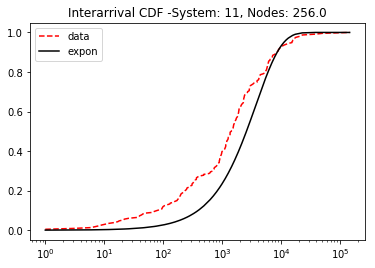

Lambda:  0.00026734637037843627 Loc:  0.9999999999999925
33


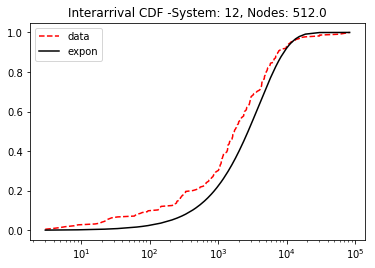

Lambda:  0.0002524191585420594 Loc:  2.999999999964772
33


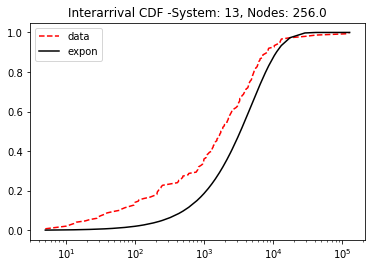

Lambda:  0.00020708675820134263 Loc:  4.999999999998182
50


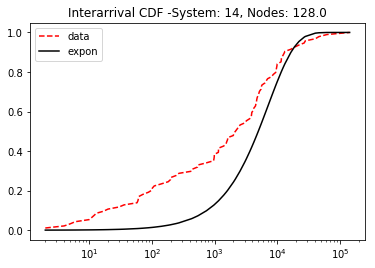

Lambda:  0.0001393788066953453 Loc:  1.9999999999999976
30


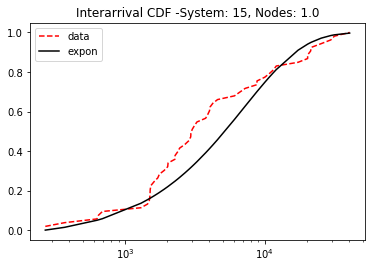

Lambda:  0.0001416438181207202 Loc:  268.99999999999517
0


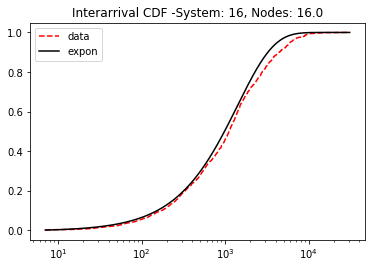

Lambda:  0.0007125469177681725 Loc:  6.999999991729228
622


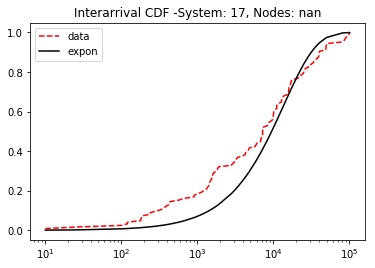

Lambda:  7.306735783249734e-05 Loc:  9.99999999956064
0


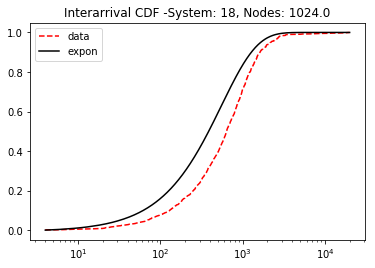

Lambda:  0.0018125542324892747 Loc:  3.9999999999895173
1095


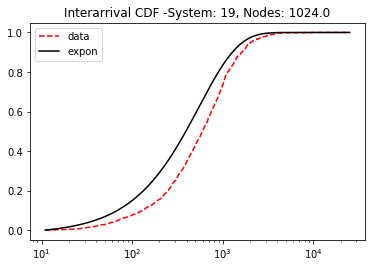

Lambda:  0.0018178630129096175 Loc:  10.999999999971724
779


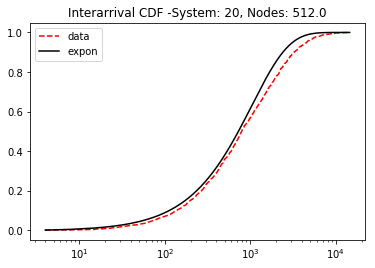

Lambda:  0.000960364497830309 Loc:  3.9999999999959837
722


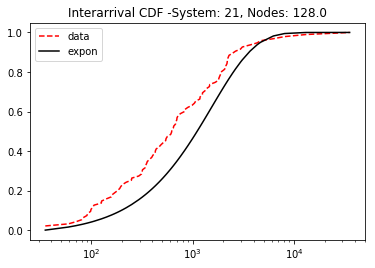

Lambda:  0.0006478538966054455 Loc:  34.999999999996795
14


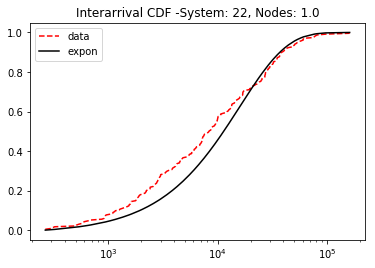

Lambda:  6.25500533976838e-05 Loc:  263.9999999999533
10


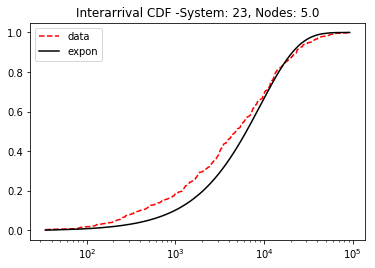

Lambda:  0.00011017485958204274 Loc:  33.999999998990916
125


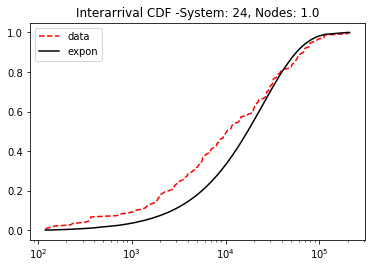

Lambda:  4.057453554533614e-05 Loc:  119.99999999999146
4
Maximum Burst Size is:  13


In [79]:
# failure rate windowing start
# failure rate for the whole system

a = np.array(date_sort.System)
cluster_data = date_sort[np.logical_or(a != 1, a != 2, a != 3)]
max_burst_size = 0

fit_dict = {}

systems = cluster_data.System.unique()
systems.sort()
for i in systems:
    # Get interarrivals
    system_data = cluster_data[cluster_data.System == i]
    
    interarrivals = system_data["Prob Started (mm/dd/yy hh:mm)"].diff()[1:]
    time_fixed = system_data["Prob Started (mm/dd/yy hh:mm)"][1:]
    
    pre = len(interarrivals)
    
    # down count outages during this one
    correlated = list(system_data["Down Time"][:-1])
    # get timedelta objects
    correlated = [datetime.timedelta(minutes=int(a)) for a in correlated]
    
    # compare to see if interarrival time can count
    truth_series = [a > b for a,b in zip(interarrivals, correlated)]
    
    if time_fixed < start+down_time
    if start-time_fixed < down
    #last problems fixed
    system_data["Prob Started (mm/dd/yy hh:mm)"][:-1][truth_series] - system_data["Prob Fixed (mm/dd/yy hh:mm)"][1:][truth_series] <= system_data["Down Time"][:-1][truth_series]
    
    
    interarrivals = interarrivals[truth_series]
    
    post = len(interarrivals)
    
    # sort interarrival times
    interarrivals.sort_values(inplace=True)
    
    # get counts
    counts = Counter(interarrivals)
    most_common, number = counts.most_common(1)[0]
    max_burst_size = max(max_burst_size, number)

    # get pdf and interarrivals in minutes
    pdf = []
    minutes = []
    for j in list(set(interarrivals)):
        pdf.append(counts[j]/len(interarrivals))
        
    for j in interarrivals:
        minutes.append(j.total_seconds()/60)
        
    minutes.sort()
    
    # get cdf
    cdf = np.cumsum(pdf)

    # get fit
    loc, scale= expon.fit(minutes)
    # get approx
    approx = expon.cdf(minutes, loc, scale)
    
    exper_x = list(set(minutes))
    exper_x.sort()
    plt.plot(exper_x, cdf, "--", color="r", label="data")
    plt.plot(minutes, approx, color="black", label="expon")
    plt.title("Interarrival CDF -System: " + str(i) + ", Nodes: " + str(system_data["nodes"].iloc[0]))
    plt.legend()
    plt.xscale('log')
    plt.show()
    
    fit_dict[i] = (minutes, pdf, cdf, scale, loc)
    
    print("Lambda: ", 1/scale, "Loc: ", loc)
    print(pre-post)

print("Maximum Burst Size is: ", max_burst_size)


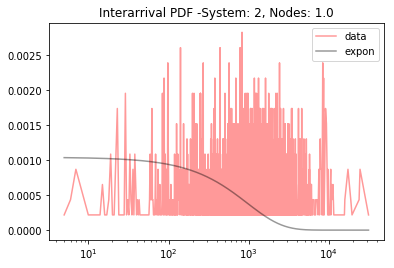

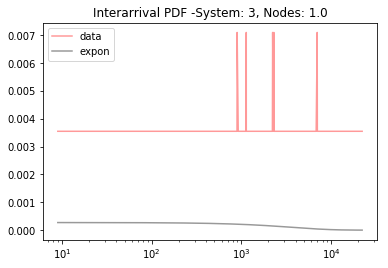

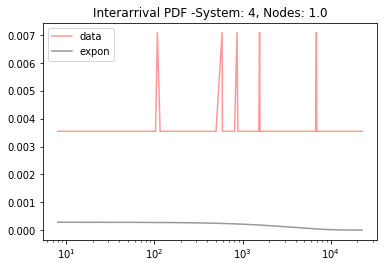

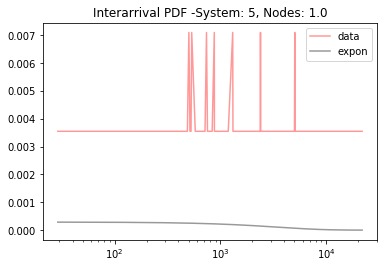

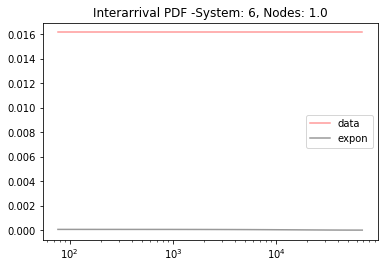

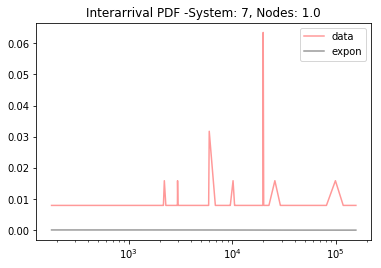

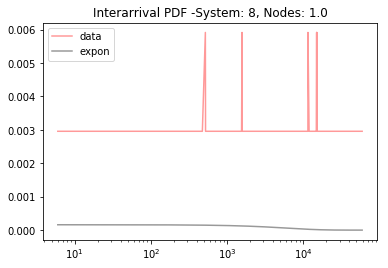

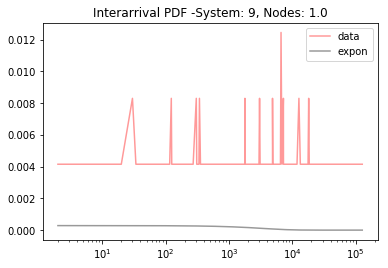

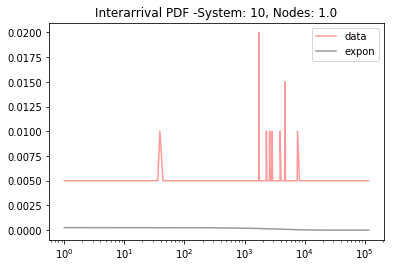

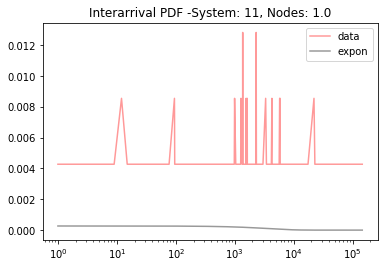

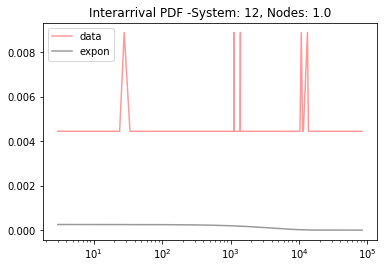

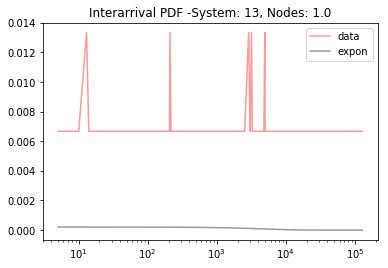

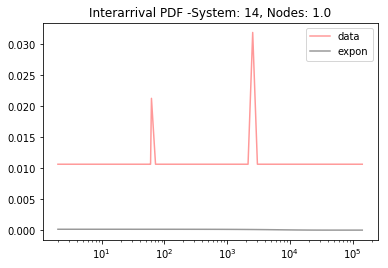

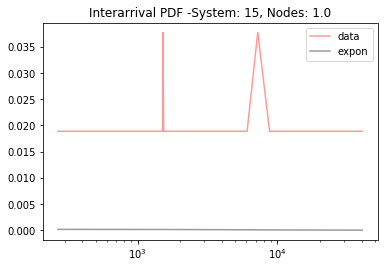

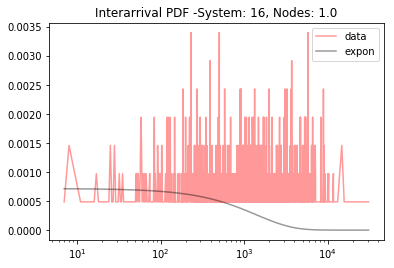

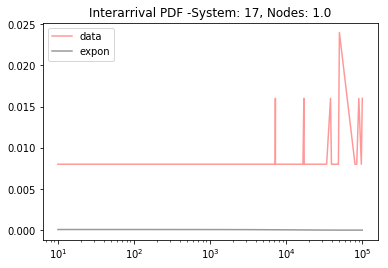

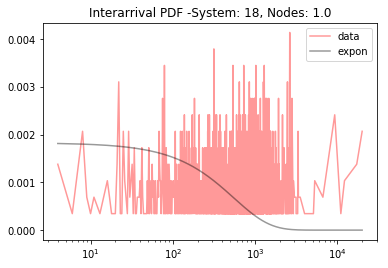

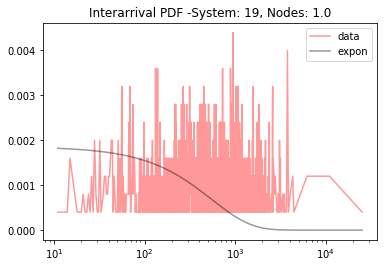

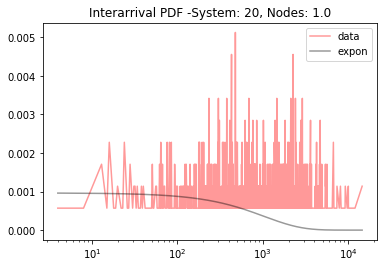

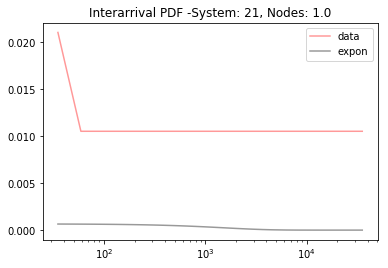

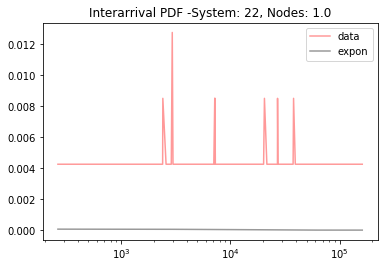

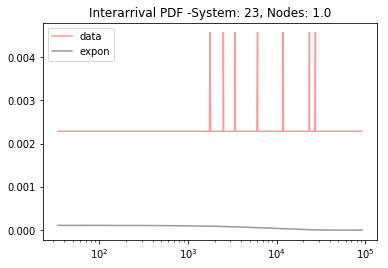

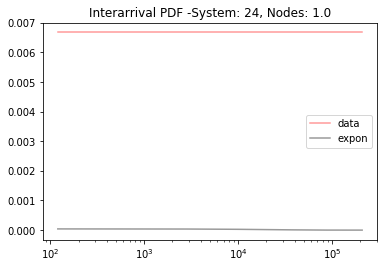

In [73]:
# plot the pdfs

systems = cluster_data.System.unique()
systems.sort()
for i in systems:
    m, p, c, s, l = fit_dict[i]
    
    a = expon.pdf(m, loc=l, scale=s)
    
    exper_x = list(set(m))
    exper_x.sort()
    plt.plot(exper_x, p, alpha=0.4, color="r", label="data")
    plt.plot(m, a, alpha=0.4, color="black", label="expon")
    plt.title("Interarrival PDF -System: " + str(i) + ", Nodes: " + str(system_data["nodes"].iloc[0]))
    plt.legend()
    plt.xscale('log')
    plt.show()


In [74]:
# KS test
def ktable(a, n):
    if a == 0.001:
        return 1.94947/(math.sqrt(n))
    if a == 0.01:
        return 1.63/(math.sqrt(n))
    if a == 0.05:
        return 1.36/(math.sqrt(n))
    if a == 0.1:
        return 1.22/(math.sqrt(n))
    
systems = cluster_data.System.unique()
systems.sort()
for i in systems:
    m, p, c, s, l = fit_dict[i]
    
    exper_x = list(set(m))
    exper_x.sort()
    
    experimental = np.array(c)
    hypothetical = np.array(expon.cdf(exper_x,l,s))
    diff = max(abs(hypothetical - experimental))
    print("Difference: ", diff)

    for alpha in [0.001]:#, 0.01, 0.05, 0.1]:
        print("Alpha: ", alpha)
        k = ktable(alpha, len(m))
        if diff > k:
            print("System" + str(i) +" is NOT exponential", diff, " > ", k)
        else:
            print("System" + str(i) +" is exponential", diff, " <= ", k)
        print(len(m))
    print()

Difference:  0.18455314373596082
Alpha:  0.001
System2 is NOT exponential 0.18455314373596082  >  0.028730878054821832
4604

Difference:  0.06262609659180357
Alpha:  0.001
System3 is exponential 0.06262609659180357  <=  0.11608924912349437
282

Difference:  0.06174608922089819
Alpha:  0.001
System4 is exponential 0.06174608922089819  <=  0.11608924912349437
282

Difference:  0.0455983966311615
Alpha:  0.001
System5 is exponential 0.0455983966311615  <=  0.11608924912349437
282

Difference:  0.06064622431695377
Alpha:  0.001
System6 is exponential 0.06064622431695377  <=  0.24758293758306138
62

Difference:  0.15799229022736022
Alpha:  0.001
System7 is exponential 0.15799229022736022  <=  0.17367259109033797
126

Difference:  0.10038791249839246
Alpha:  0.001
System8 is exponential 0.10038791249839246  <=  0.10603718897844146
338

Difference:  0.166647071964884
Alpha:  0.001
System9 is NOT exponential 0.166647071964884  >  0.12557640184696278
241

Difference:  0.13200879947596905
Alpha:

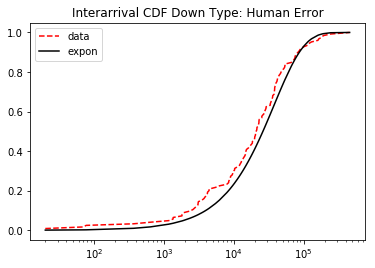

Lambda:  2.6528251288311568e-05 Loc:  19.999999999952816


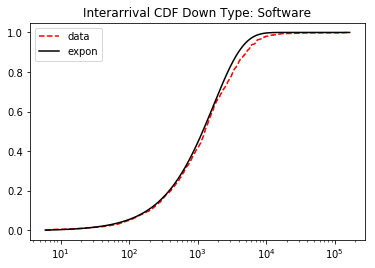

Lambda:  0.0005867697675611636 Loc:  5.999999999996558


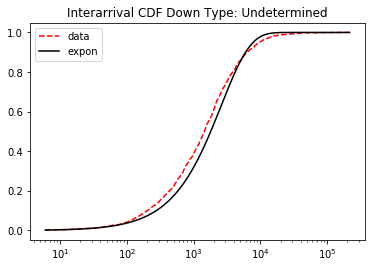

Lambda:  0.00038474809472343675 Loc:  5.9999999999635305


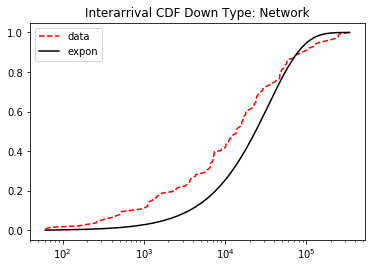

Lambda:  2.939720932841494e-05 Loc:  60.99999999994809


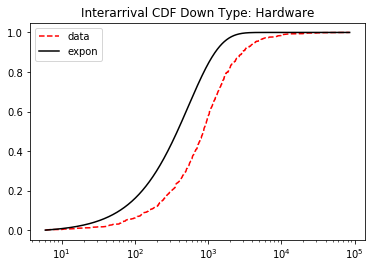

Lambda:  0.0018525427222426157 Loc:  5.999999505083692


In [94]:
# plot the exponential by outage type
down_types = ["Human Error", "Software", "Undetermined", "Network", "Hardware"]
down_type_fit_dict = {}

# only get the data from some systems
# a = np.array(date_sort.System)
# cluster_data = date_sort[np.logical_or(a != 1, a != 2, a != 3)]
cluster_data = date_sort

for i in down_types:
    temp_df = cluster_data[[i,"Prob Started (mm/dd/yy hh:mm)"]].dropna()
    interarrivals = temp_df["Prob Started (mm/dd/yy hh:mm)"].diff()[1:]
    
    # down count outages during this one
    correlated = list(cluster_data["Down Time"][:-1])
    # get timedelta objects
    correlated = [datetime.timedelta(minutes=int(a)) for a in correlated]
    # compare to see if interarrival time can count
    truth_series = [a > b for a,b in zip(interarrivals, correlated)]
    interarrivals = interarrivals[truth_series]
    # sort interarrival times
    interarrivals.sort_values(inplace=True)
    
    # get counts
    counts = Counter(interarrivals)
    most_common, number = counts.most_common(1)[0]
    max_burst_size = max(max_burst_size, number)

    # get pdf and interarrivals in minutes
    pdf = []
    minutes = []
    for j in list(set(interarrivals)):
        pdf.append(counts[j]/len(interarrivals))
        
    for j in interarrivals:
        minutes.append(j.total_seconds()/60)
        
    minutes.sort()
    
    # get cdf
    cdf = np.cumsum(pdf)

    # get fit
    loc, scale= expon.fit(minutes)
    # get approx
    approx = expon.cdf(minutes, loc, scale)
    
    exper_x = list(set(minutes))
    exper_x.sort()
    plt.plot(exper_x, cdf, "--", color="r", label="data")
    plt.plot(minutes, approx, color="black", label="expon")
    plt.title("Interarrival CDF Down Type: " + str(i))
    plt.legend()
    plt.xscale('log')
    plt.show()
    
    down_type_fit_dict[i] = (minutes, pdf, cdf, scale, loc)
    
    print("Lambda: ", 1/scale, "Loc: ", loc)
    

In [95]:
for i in down_types:
    m, p, c, s, l = down_type_fit_dict[i]
    
    exper_x = list(set(m))
    exper_x.sort()
    
    experimental = np.array(c)
    hypothetical = np.array(expon.cdf(exper_x,l,s))
    diff = max(abs(hypothetical - experimental))
    print("Difference: ", diff)

    for alpha in [0.001]:#, 0.01, 0.05, 0.1]:
        print("Alpha: ", alpha)
        k = ktable(alpha, len(m))
        if diff > k:
            print("Down Type: " + str(i) +" is NOT exponential", diff, " > ", k)
        else:
            print("Down Type: " + str(i) +" is exponential", diff, " <= ", k)
    print(len(m)) 
    print()

Difference:  0.10185895162868419
Alpha:  0.001
Down Type: Human Error is exponential 0.10185895162868419  <=  0.1743658976038606
125

Difference:  0.05927163319869322
Alpha:  0.001
Down Type: Software is NOT exponential 0.05927163319869322  >  0.034901111587341334
3120

Difference:  0.08165460490982335
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.08165460490982335  >  0.042910315708865346
2064

Difference:  0.20257159450856535
Alpha:  0.001
Down Type: Network is NOT exponential 0.20257159450856535  >  0.16535188727432132
139

Difference:  0.31440772464905886
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.31440772464905886  >  0.020401278519991007
9131



[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


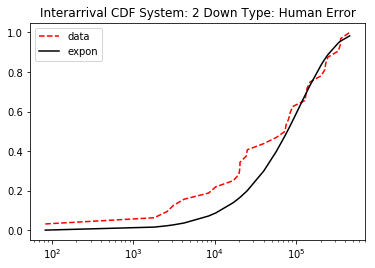

Lambda:  8.878028595224797e-06 Loc:  82.99999999981566
Difference:  0.8563489342558969
Alpha:  0.001
Down Type: Human Error is NOT exponential 0.8563489342558969  >  0.3446208641799347
32



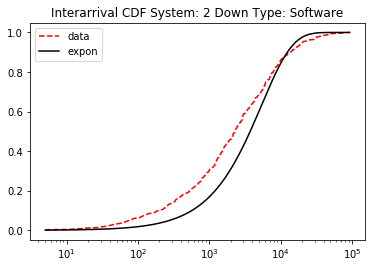

Lambda:  0.00018517985166285783 Loc:  4.999999999851104
Difference:  0.962053386676989
Alpha:  0.001
Down Type: Software is NOT exponential 0.962053386676989  >  0.06734332369951289
838



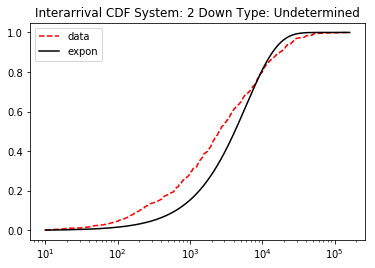

Lambda:  0.00016655714686498023 Loc:  9.999999999999945
Difference:  0.9391954700345261
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9391954700345261  >  0.07108985624385013
752



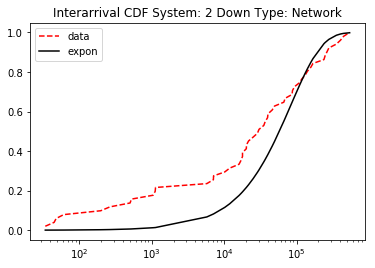

Lambda:  1.2049499361874548e-05 Loc:  33.999999999963336
Difference:  0.9551490366040879
Alpha:  0.001
Down Type: Network is NOT exponential 0.9551490366040879  >  0.2729804015410084
51



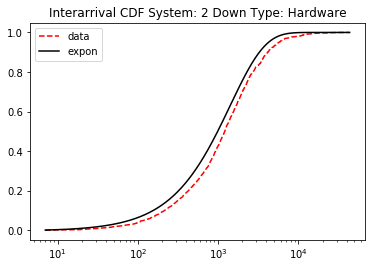

Lambda:  0.0007069902947353297 Loc:  6.999999999998829
Difference:  0.995995669326881
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.995995669326881  >  0.034756592906166874
3146



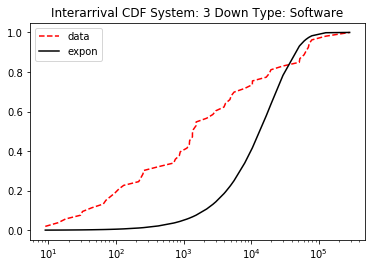

Lambda:  5.1622502659108837e-05 Loc:  8.999999999964087
Difference:  0.9797361216247866
Alpha:  0.001
Down Type: Software is NOT exponential 0.9797361216247866  >  0.2677802986010508
53



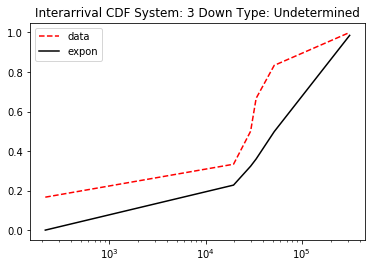

Lambda:  1.336916027201188e-05 Loc:  214.99999999650547
Difference:  0.9999999999999531
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9999999999999531  >  0.7958677948105871
6



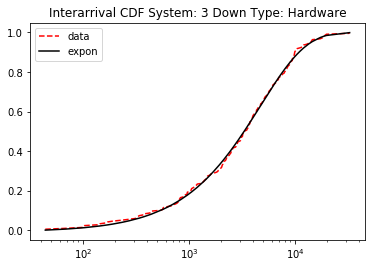

Lambda:  0.00021219429615593145 Loc:  43.999999999996014
Difference:  0.8256509860330554
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.8256509860330554  >  0.13173297470684459
219



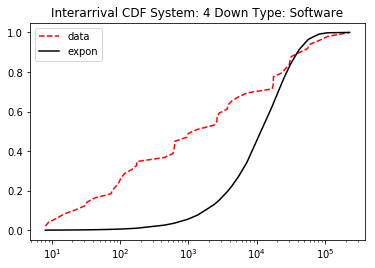

Lambda:  5.854128780747757e-05 Loc:  7.999999846044203
Difference:  0.912064832535745
Alpha:  0.001
Down Type: Software is NOT exponential 0.912064832535745  >  0.2784957142857143
49



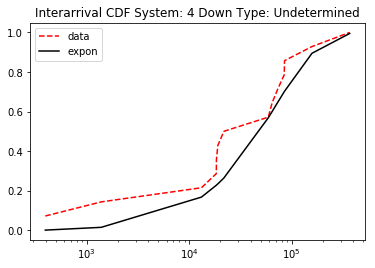

Lambda:  1.43289634843561e-05 Loc:  393.99999999998596
Difference:  0.7658989803827232
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.7658989803827232  >  0.521017773271014
14



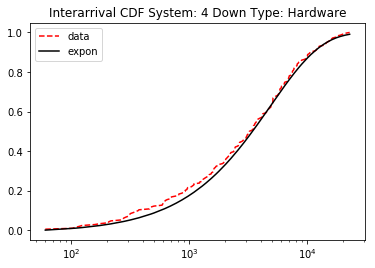

Lambda:  0.0002061822055848002 Loc:  59.999999987350584
Difference:  0.8758900584053575
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.8758900584053575  >  0.13326302571567702
214



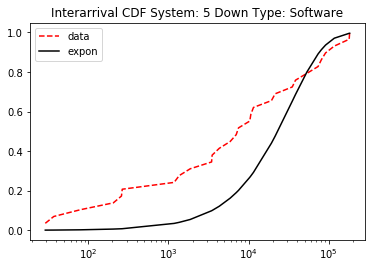

Lambda:  3.007445512717857e-05 Loc:  28.999999986008408
Difference:  0.9611210893129932
Alpha:  0.001
Down Type: Software is NOT exponential 0.9611210893129932  >  0.3620074909160173
29



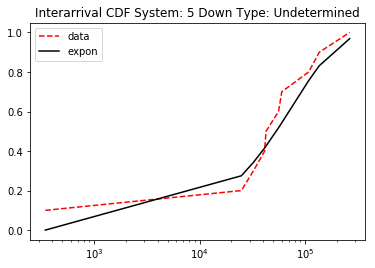

Lambda:  1.3079722461049557e-05 Loc:  344.9999999816225
Difference:  0.8999999999997595
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.8999999999997595  >  0.6164765430168451
10



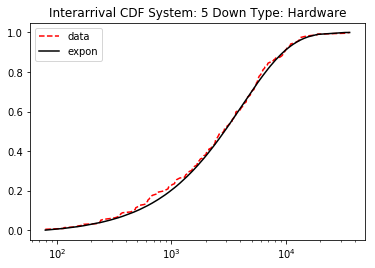

Lambda:  0.00024537736682278983 Loc:  78.99999999998309
Difference:  0.8928210451096724
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.8928210451096724  >  0.1261007314838147
239



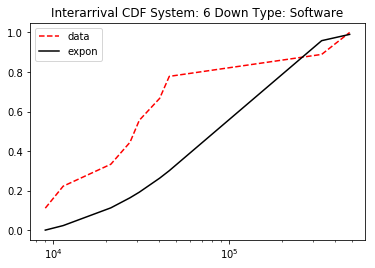

Lambda:  9.75297849587258e-06 Loc:  9039.99999999998
Difference:  0.977055239303985
Alpha:  0.001
Down Type: Software is NOT exponential 0.977055239303985  >  0.6498233333333333
9



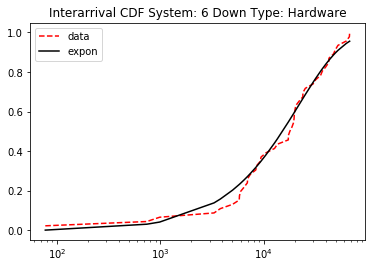

Lambda:  4.580034017649356e-05 Loc:  76.99999762305407
Difference:  0.9113794144533013
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.9113794144533013  >  0.2874336702652873
46



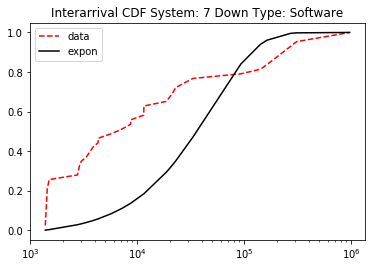

Lambda:  2.0060404281215433e-05 Loc:  1379.9999999998313
Difference:  0.8139534883720898
Alpha:  0.001
Down Type: Software is NOT exponential 0.8139534883720898  >  0.29729138790630283
43



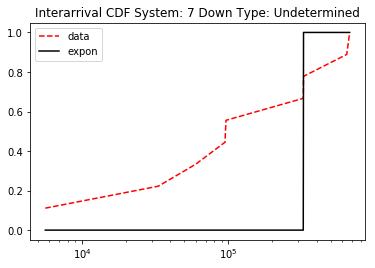

Lambda:  0.15578144085401874 Loc:  324419.99999545526
Difference:  0.8888888888888891
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.8888888888888891  >  0.6498233333333333
9



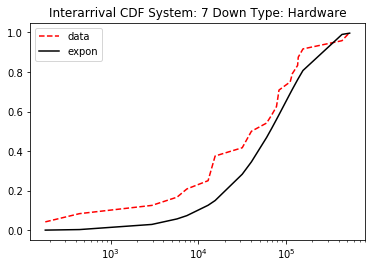

Lambda:  1.0550359940574027e-05 Loc:  178.99999999988415
Difference:  0.8016651029685435
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.8016651029685435  >  0.39793389740529356
24



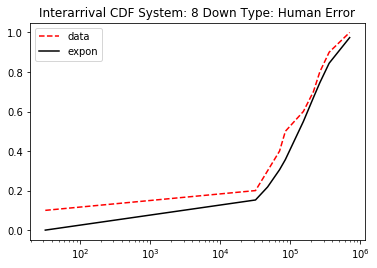

Lambda:  5.191507028606676e-06 Loc:  31.999999999627452
Difference:  0.7819185091948873
Alpha:  0.001
Down Type: Human Error is NOT exponential 0.7819185091948873  >  0.6164765430168451
10



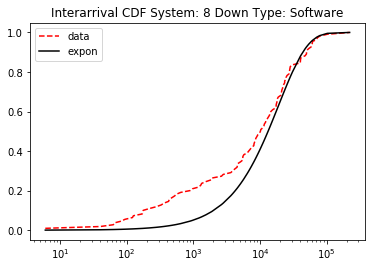

Lambda:  5.244010792535265e-05 Loc:  5.999999999980667
Difference:  0.9498943644288279
Alpha:  0.001
Down Type: Software is NOT exponential 0.9498943644288279  >  0.1858746713856605
110



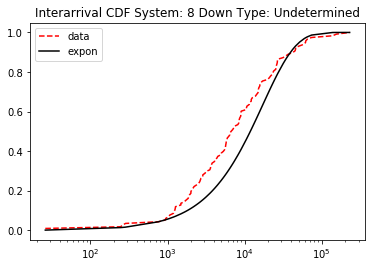

Lambda:  5.861889104087385e-05 Loc:  25.999999999995786
Difference:  0.8794965127411222
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.8794965127411222  >  0.17946326003542445
118



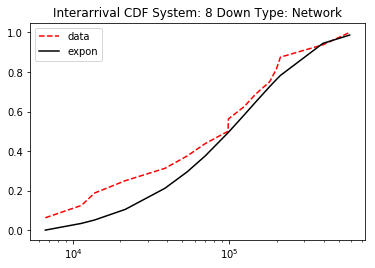

Lambda:  7.434816088451588e-06 Loc:  6619.999999999829
Difference:  0.9374999999999988
Alpha:  0.001
Down Type: Network is NOT exponential 0.9374999999999988  >  0.4873675
16



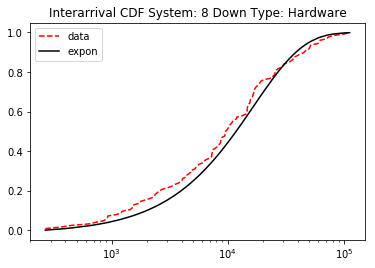

Lambda:  6.003058267858729e-05 Loc:  268.99999999999716
Difference:  0.8806460490080089
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.8806460490080089  >  0.17367259109033797
126



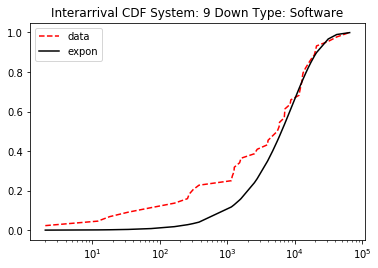

Lambda:  0.00010919471652419154 Loc:  1.9999999999966624
Difference:  0.9369421471391522
Alpha:  0.001
Down Type: Software is NOT exponential 0.9369421471391522  >  0.29389366045700643
44



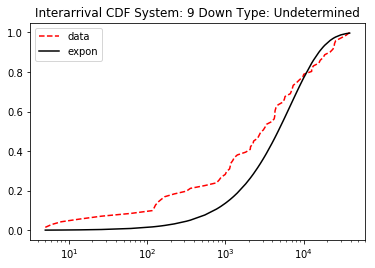

Lambda:  0.0001470275826634021 Loc:  4.999999999900306
Difference:  0.9828003769832983
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9828003769832983  >  0.23135952391991713
71



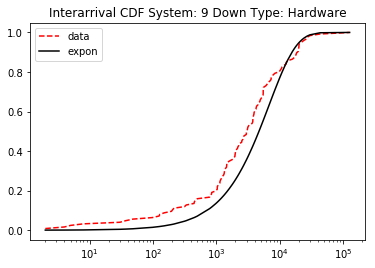

Lambda:  0.00014741636728920218 Loc:  1.99999999999971
Difference:  0.9194297811329338
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.9194297811329338  >  0.17367259109033797
126



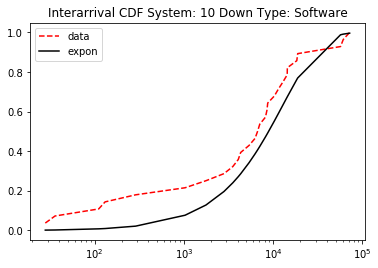

Lambda:  7.807767192644904e-05 Loc:  27.999999995253127
Difference:  0.8863976488964267
Alpha:  0.001
Down Type: Software is NOT exponential 0.8863976488964267  >  0.3684152005986491
28



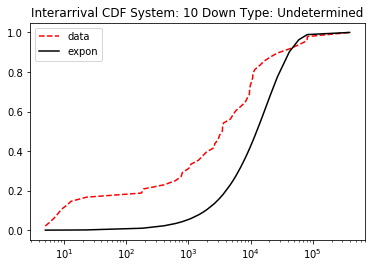

Lambda:  5.532210502548527e-05 Loc:  4.999999999999901
Difference:  0.9380995855142249
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9380995855142249  >  0.28138175731927495
48



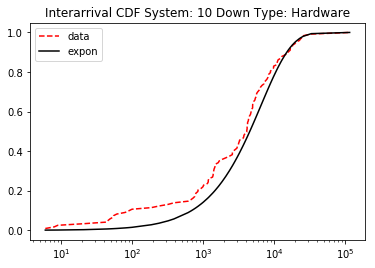

Lambda:  0.00015189461711185602 Loc:  5.999999999987152
Difference:  0.8572538969710763
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.8572538969710763  >  0.17577779026951193
123



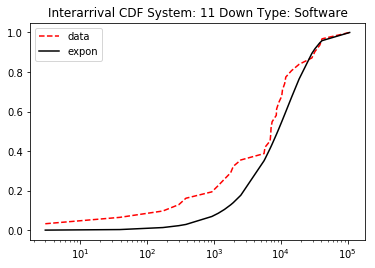

Lambda:  7.727763332412836e-05 Loc:  2.999999999995544
Difference:  0.9390285615623342
Alpha:  0.001
Down Type: Software is NOT exponential 0.9390285615623342  >  0.3501351481421369
31



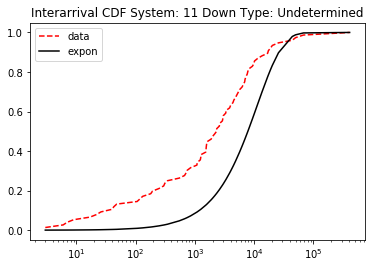

Lambda:  8.861145186551717e-05 Loc:  2.9999999999814766
Difference:  0.9258925770313091
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9258925770313091  >  0.22361954535432202
76



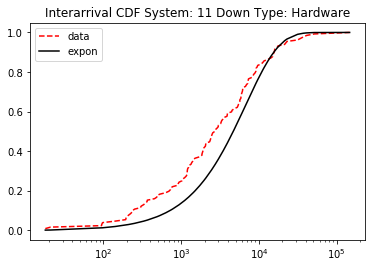

Lambda:  0.00014862572212409652 Loc:  17.999999999998963
Difference:  0.9674246781158389
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.9674246781158389  >  0.16967958397797714
132



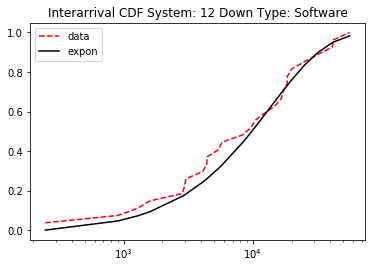

Lambda:  7.210979721345614e-05 Loc:  247.9999999999876
Difference:  0.9629629629629615
Alpha:  0.001
Down Type: Software is NOT exponential 0.9629629629629615  >  0.37517567642569993
27



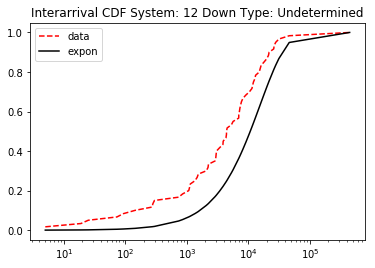

Lambda:  6.475569560396054e-05 Loc:  4.999999986898767
Difference:  0.9057909827844385
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9057909827844385  >  0.2516754947976991
60



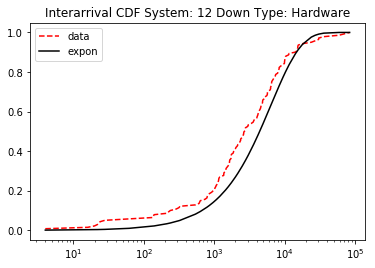

Lambda:  0.00015700772061329242 Loc:  3.999999999988724
Difference:  0.9032254769438168
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.9032254769438168  >  0.16417499055615467
141



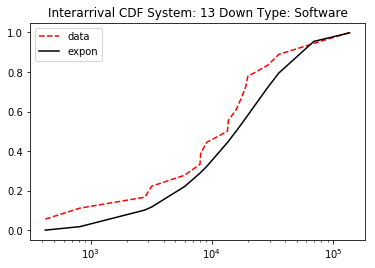

Lambda:  4.495302618716714e-05 Loc:  423.99999999997436
Difference:  0.8828810174214111
Alpha:  0.001
Down Type: Software is NOT exponential 0.8828810174214111  >  0.4594944855732463
18



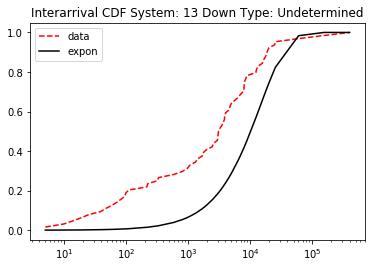

Lambda:  6.796442804902605e-05 Loc:  4.999999999987228
Difference:  0.9303216588816197
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9303216588816197  >  0.24368375
64



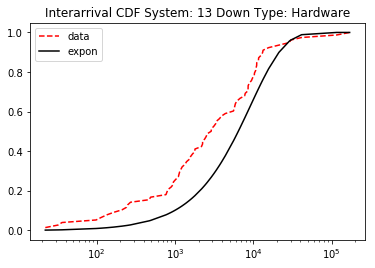

Lambda:  0.00010808278624087345 Loc:  21.999999999998522
Difference:  0.9743589642675352
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.9743589642675352  >  0.2207340109753865
78



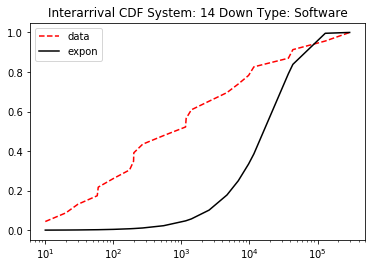

Lambda:  4.1994022726572094e-05 Loc:  9.999999999992884
Difference:  0.9532546655373724
Alpha:  0.001
Down Type: Software is NOT exponential 0.9532546655373724  >  0.4064925947718456
23



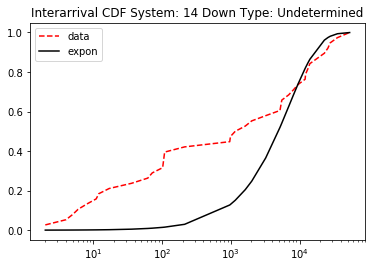

Lambda:  0.00014117577492422521 Loc:  1.9999999999925295
Difference:  0.9586919230012667
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9586919230012667  >  0.3162457938517877
38



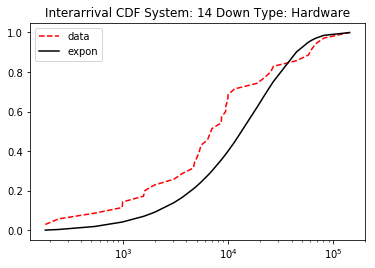

Lambda:  5.228995677245605e-05 Loc:  181.99999997837813
Difference:  0.8824254385815037
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.8824254385815037  >  0.32952057299312026
35



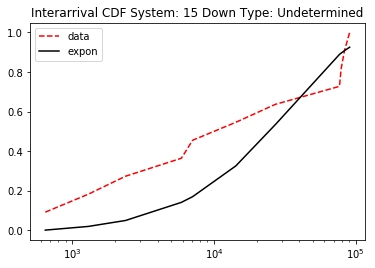

Lambda:  2.88464831772058e-05 Loc:  645.9999999999968
Difference:  0.8308468410349962
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.8308468410349962  >  0.5877873209140129
11



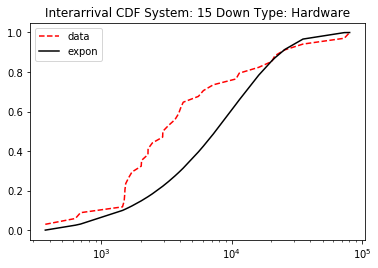

Lambda:  9.716812061893773e-05 Loc:  369.99999999996965
Difference:  0.9456409809285643
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.9456409809285643  >  0.3343313467777667
34



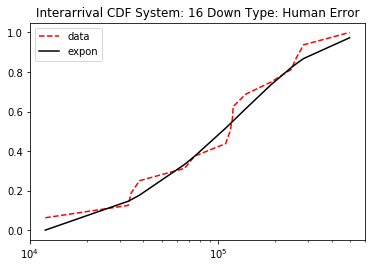

Lambda:  7.457922703946544e-06 Loc:  12076.999454753444
Difference:  0.7857443048340291
Alpha:  0.001
Down Type: Human Error is NOT exponential 0.7857443048340291  >  0.4873675
16



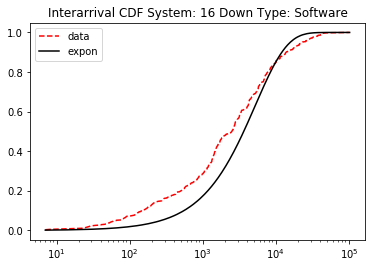

Lambda:  0.00019026881785102204 Loc:  6.999999998514781
Difference:  0.9087570168146515
Alpha:  0.001
Down Type: Software is NOT exponential 0.9087570168146515  >  0.08381426169674702
541



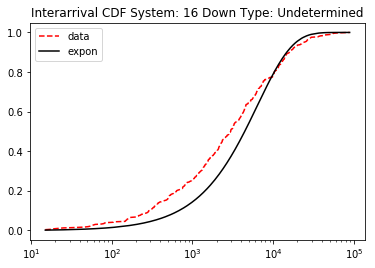

Lambda:  0.00015652682381174827 Loc:  14.999999999993012
Difference:  0.9800555719539952
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9800555719539952  >  0.09169535556438857
452



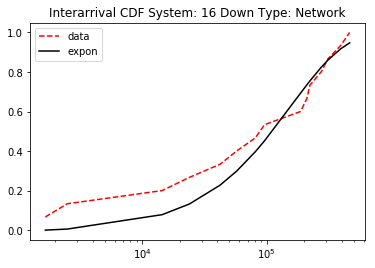

Lambda:  6.375598111932472e-06 Loc:  1659.999246840514
Difference:  0.9280365330841547
Alpha:  0.001
Down Type: Network is NOT exponential 0.9280365330841547  >  0.5033509895953981
15



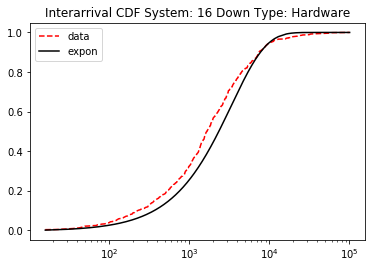

Lambda:  0.000297165182870566 Loc:  15.999999997079337
Difference:  0.9066298643299011
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.9066298643299011  >  0.06667046726798151
855



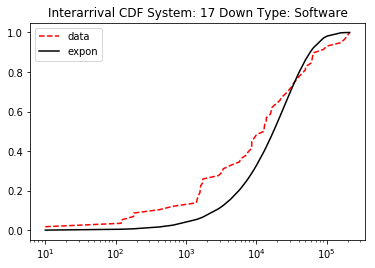

Lambda:  3.9468668874925826e-05 Loc:  9.999999999979533
Difference:  0.9119467441910685
Alpha:  0.001
Down Type: Software is NOT exponential 0.9119467441910685  >  0.25597795166704335
58



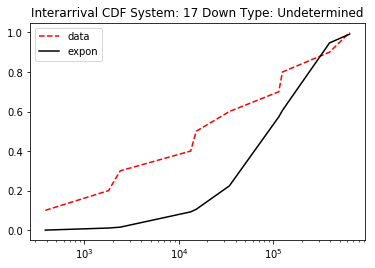

Lambda:  7.504493231570698e-06 Loc:  384.99999999979167
Difference:  0.7850883016827619
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.7850883016827619  >  0.6164765430168451
10



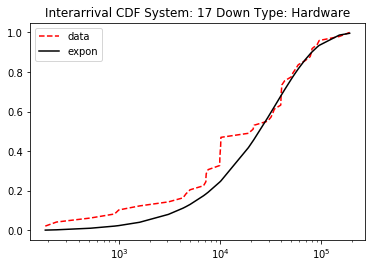

Lambda:  2.877467980078998e-05 Loc:  185.9999999999567
Difference:  0.920363869740286
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.920363869740286  >  0.2784957142857143
49



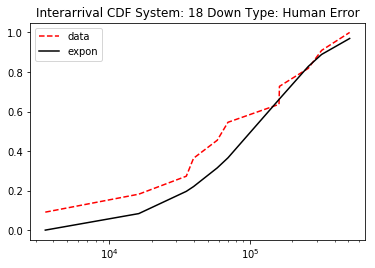

Lambda:  6.863010894389856e-06 Loc:  3514.9999999999036
Difference:  0.8181818181818177
Alpha:  0.001
Down Type: Human Error is NOT exponential 0.8181818181818177  >  0.5877873209140129
11



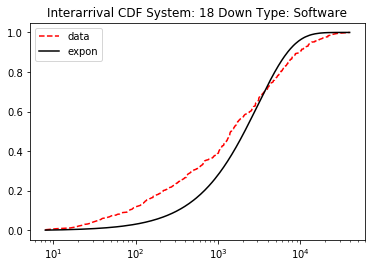

Lambda:  0.00033069855011732825 Loc:  7.9999999999987494
Difference:  0.9516938349963965
Alpha:  0.001
Down Type: Software is NOT exponential 0.9516938349963965  >  0.08305021419513883
551



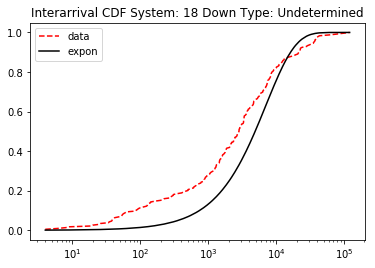

Lambda:  0.00014100961094507965 Loc:  3.999999999992734
Difference:  0.9922301788500436
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9922301788500436  >  0.1261007314838147
239



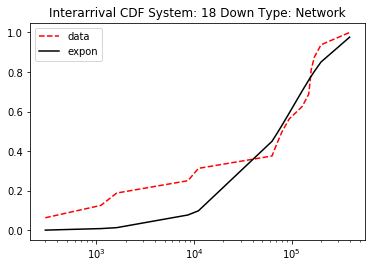

Lambda:  9.513156613778612e-06 Loc:  299.99999999177624
Difference:  0.923453683322677
Alpha:  0.001
Down Type: Network is NOT exponential 0.923453683322677  >  0.4873675
16



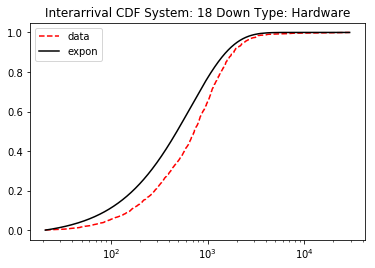

Lambda:  0.0015023348988190326 Loc:  20.99999999999614
Difference:  0.975748527050312
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.975748527050312  >  0.039563273207124994
2428



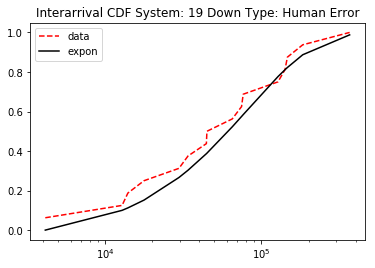

Lambda:  1.214745779559809e-05 Loc:  4123.999999999886
Difference:  0.9374999999999986
Alpha:  0.001
Down Type: Human Error is NOT exponential 0.9374999999999986  >  0.4873675
16



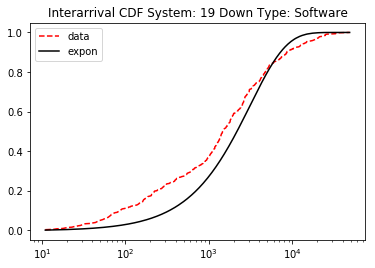

Lambda:  0.0003202280237707141 Loc:  10.99999999999385
Difference:  0.9207903704169775
Alpha:  0.001
Down Type: Software is NOT exponential 0.9207903704169775  >  0.09030745387346106
466



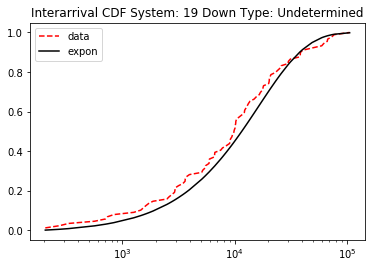

Lambda:  6.097836726544356e-05 Loc:  204.9999999999671
Difference:  0.9222128071239283
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9222128071239283  >  0.20664340671359988
89



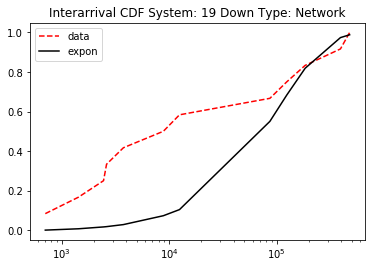

Lambda:  9.290406088560395e-06 Loc:  704.9999999996097
Difference:  0.8990328667246319
Alpha:  0.001
Down Type: Network is NOT exponential 0.8990328667246319  >  0.5627635146385499
12



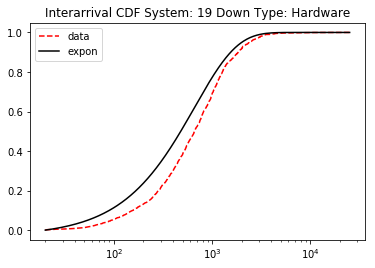

Lambda:  0.0015080586598502047 Loc:  19.99999999999994
Difference:  0.9722234298183147
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.9722234298183147  >  0.04223036464697883
2131



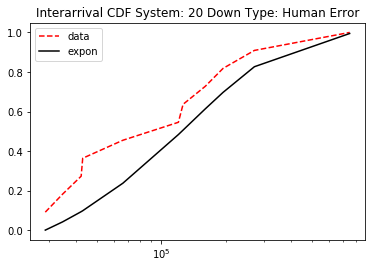

Lambda:  7.249075031482026e-06 Loc:  28899.999999999818
Difference:  0.7202088025213277
Alpha:  0.001
Down Type: Human Error is NOT exponential 0.7202088025213277  >  0.5877873209140129
11



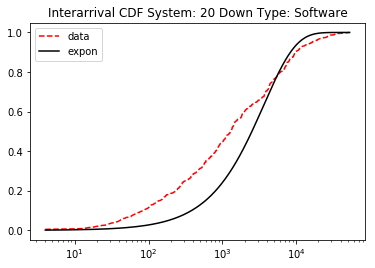

Lambda:  0.0002756474691596997 Loc:  3.9999999984810977
Difference:  0.8728149328478081
Alpha:  0.001
Down Type: Software is NOT exponential 0.8728149328478081  >  0.08590391201124052
515



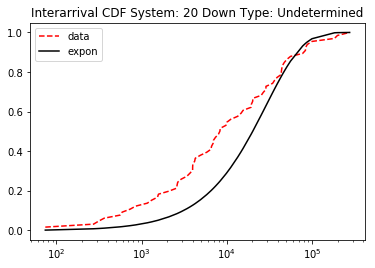

Lambda:  3.449007472117073e-05 Loc:  73.99999999995566
Difference:  0.8536499505981401
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.8536499505981401  >  0.23996316891947977
66



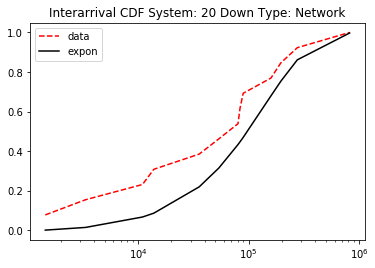

Lambda:  7.193928776120162e-06 Loc:  1449.999999999975
Difference:  0.9863606602903467
Alpha:  0.001
Down Type: Network is NOT exponential 0.9863606602903467  >  0.5406856957675987
13



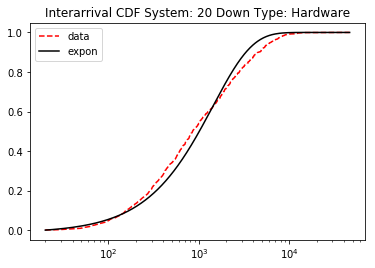

Lambda:  0.0006994645925082455 Loc:  19.99999999999727
Difference:  0.9855117537217635
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.9855117537217635  >  0.05380023755033245
1313



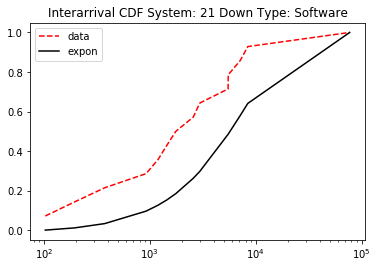

Lambda:  0.0001234121719003853 Loc:  102.99999999998533
Difference:  0.8325486136851318
Alpha:  0.001
Down Type: Software is NOT exponential 0.8325486136851318  >  0.521017773271014
14



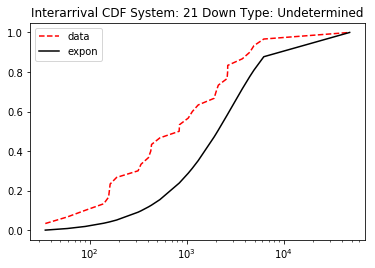

Lambda:  0.0003384096456387078 Loc:  34.99999999995714
Difference:  0.966666569405166
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.966666569405166  >  0.3559228980598654
30



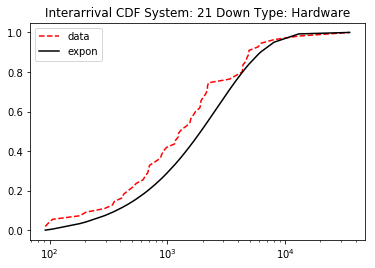

Lambda:  0.00037738763383802484 Loc:  91.99999999996993
Difference:  0.8961650240200332
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.8961650240200332  >  0.2628664811752433
55



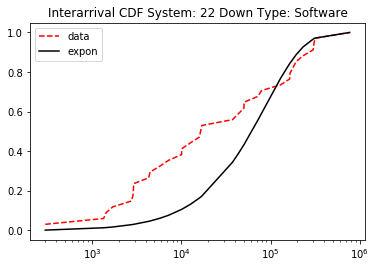

Lambda:  1.132065423911237e-05 Loc:  299.9999999999792
Difference:  0.9411438942710526
Alpha:  0.001
Down Type: Software is NOT exponential 0.9411438942710526  >  0.3343313467777667
34



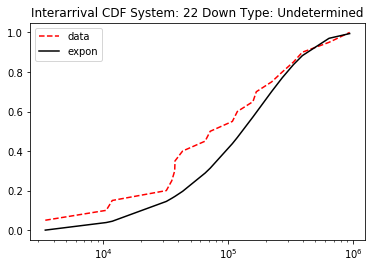

Lambda:  5.49806295904968e-06 Loc:  3424.999999999929
Difference:  0.589025093752063
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.589025093752063  >  0.43591474400965147
20



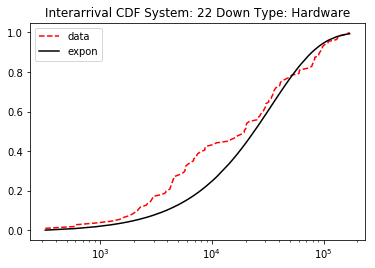

Lambda:  2.9351726657422698e-05 Loc:  321.999999997342
Difference:  0.943994555843223
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.943994555843223  >  0.18503550379796244
111



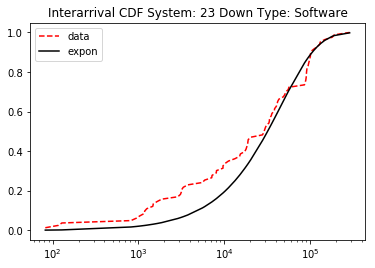

Lambda:  2.1709028628204233e-05 Loc:  81.99999999993352
Difference:  0.9269513159585893
Alpha:  0.001
Down Type: Software is NOT exponential 0.9269513159585893  >  0.21398213192210164
83



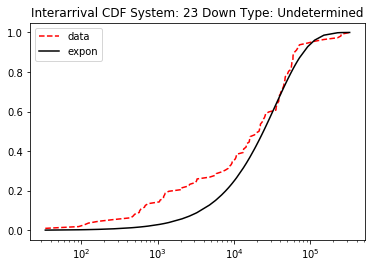

Lambda:  2.8611916047400936e-05 Loc:  33.99999999982185
Difference:  0.9688417327088866
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.9688417327088866  >  0.18420760029932454
112



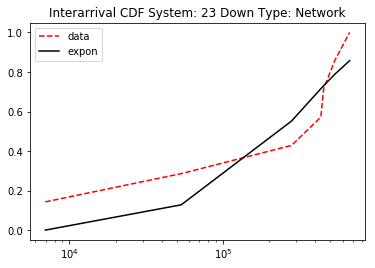

Lambda:  2.9453427976251926e-06 Loc:  6954.989138154717
Difference:  0.5876707003377066
Alpha:  0.001
Down Type: Network is exponential 0.5876707003377066  <=  0.7368304011972981
7



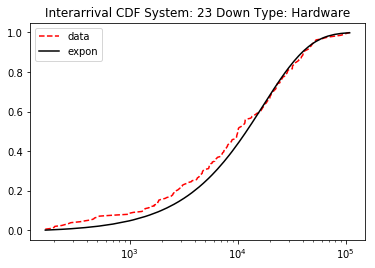

Lambda:  5.8200348259242386e-05 Loc:  164.99999999999585
Difference:  0.9571068171851753
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.9571068171851753  >  0.1338901493005254
212



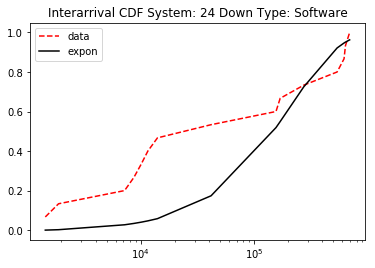

Lambda:  4.74142602446019e-06 Loc:  1439.9999999990398
Difference:  0.9531949639243247
Alpha:  0.001
Down Type: Software is NOT exponential 0.9531949639243247  >  0.5033509895953981
15



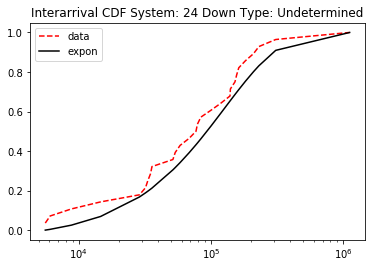

Lambda:  7.908196838760487e-06 Loc:  5579.9999999995725
Difference:  0.7599293932158476
Alpha:  0.001
Down Type: Undetermined is NOT exponential 0.7599293932158476  >  0.3684152005986491
28



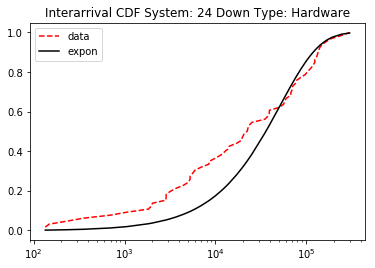

Lambda:  1.9338620605978337e-05 Loc:  133.99999916394148
Difference:  0.8840167804931155
Alpha:  0.001
Down Type: Hardware is NOT exponential 0.8840167804931155  >  0.23996316891947977
66



In [96]:
# plot the exponential by outage type
down_types = ["Human Error", "Software", "Undetermined", "Network", "Hardware"]
# down_type_fit_dict = {}

# only get the data from some systems
# a = np.array(date_sort.System)
# cluster_data = date_sort[np.logical_or(a != 1, a != 2, a != 3)]
systems = date_sort.System.unique()
systems.sort()
print(systems)

for s in systems:
    cluster_data = date_sort[date_sort.System == s]

    for i in down_types:
        temp_df = cluster_data[[i,"Prob Started (mm/dd/yy hh:mm)", "Down Time"]].dropna()
        interarrivals = temp_df["Prob Started (mm/dd/yy hh:mm)"].diff()[1:]
        # down count outages during this one
        correlated = list(temp_df["Down Time"][:-1])
        # get timedelta objects
        correlated = [datetime.timedelta(minutes=int(a)) for a in correlated]
        # compare to see if interarrival time can count
        truth_series = [a > b for a,b in zip(interarrivals, correlated)]
        interarrivals = interarrivals[truth_series]
        # sort interarrival times
        interarrivals.sort_values(inplace=True)
        
        if (len(interarrivals) < 5):
            continue
        
        # get counts
        counts = Counter(interarrivals)
        most_common, number = counts.most_common(1)[0]
        max_burst_size = max(max_burst_size, number)

        # get pdf and interarrivals in minutes
        pdf = []
        minutes = []
        for j in list(set(interarrivals)):
            pdf.append(counts[j]/len(interarrivals))

        for j in interarrivals:
            minutes.append(j.total_seconds()/60)

        minutes.sort()

        # get cdf
        cdf = np.cumsum(pdf)

        # get fit
        loc, scale= expon.fit(minutes)
        # get approx
        approx = expon.cdf(minutes, loc, scale)

        exper_x = list(set(minutes))
        exper_x.sort()
        plt.plot(exper_x, cdf, "--", color="r", label="data")
        plt.plot(minutes, approx, color="black", label="expon")
        plt.title("Interarrival CDF System: "+ str(s) + " Down Type: " + str(i))
        plt.legend()
        plt.xscale('log')
        plt.show()

#         down_type_fit_dict[i] = (minutes, pdf, cdf, scale, loc)

        print("Lambda: ", 1/scale, "Loc: ", loc)

        experimental = np.array(cdf)
        hypothetical = np.array(expon.cdf(list(set(minutes)), loc=loc, scale=scale))
        diff = max(abs(hypothetical - experimental))
        print("Difference: ", diff)

        for alpha in [0.001]:#, 0.01, 0.05, 0.1]:
            print("Alpha: ", alpha)
            k = ktable(alpha, len(minutes))
            if diff > k:
                print("Down Type: " + str(i) +" is NOT exponential", diff, " > ", k)
            else:
                print("Down Type: " + str(i) +" is exponential", diff, " <= ", k)
        print(len(minutes)) 
        print()
    

In [221]:
a = np.array(lanl.System)
E = lanl[np.logical_or(a == 9, np.logical_or(a == 10, a == 11))]
a = np.array(lanl.System)
# a == 16, a==17
F = lanl[np.logical_or(np.logical_or(a == 14, a == 15), np.logical_or(a == 16, a==17))]

# date_sort = lanl
# change to datetime objects
E["Prob Started (mm/dd/yy hh:mm)"] = pd.to_datetime(E["Prob Started (mm/dd/yy hh:mm)"])
E["Prob Fixed (mm/dd/yy hh:mm)"] = pd.to_datetime(E["Prob Fixed (mm/dd/yy hh:mm)"])
E = E.sort_values("Prob Started (mm/dd/yy hh:mm)")

F["Prob Started (mm/dd/yy hh:mm)"] = pd.to_datetime(F["Prob Started (mm/dd/yy hh:mm)"])
F["Prob Fixed (mm/dd/yy hh:mm)"] = pd.to_datetime(F["Prob Fixed (mm/dd/yy hh:mm)"])
F = F.sort_values("Prob Started (mm/dd/yy hh:mm)")    

C:\Users\nickh_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\nickh_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\nickh_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

System:  9
Start Date:  2003-09-03 00:00:00
First Time:  2003-10-29 10:30:00
Last Time:  2005-09-07 12:35:00
Minutes:  1059156


<Figure size 432x288 with 0 Axes>

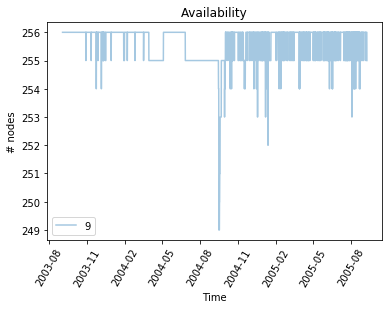

System:  10
Start Date:  2003-09-03 00:00:00
First Time:  2003-11-03 12:00:00
Last Time:  2005-08-31 10:03:00
Minutes:  1048924


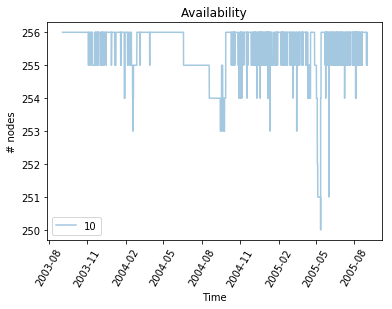

System:  11
Start Date:  2003-09-03 00:00:00
First Time:  2003-11-08 05:04:00
Last Time:  2005-09-06 16:44:00
Minutes:  1057965


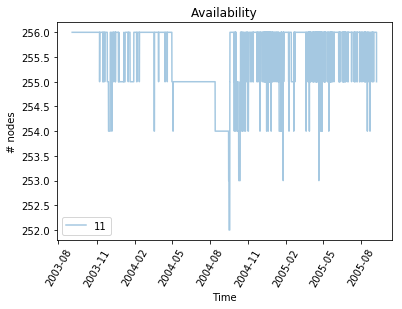

In [280]:
month_to_num = {"Jan" : 1,
                "Feb" : 2,
                "Mar" : 3,
                "Apr" : 4,
                "May" : 5,
                "Jun" : 6,
                "Jul" : 7,
                "Aug" : 8,
                "Sep" : 9,
                "Oct" : 10,
                "Nov" : 11,
                "Dec" : 12}

F_to_year = {14 : 2003,
             15 : 2004,
             16 : 1996,
             17 : 1997}

avail_dict = {}

work_hours = False
clock_in = 8
clock_out = 18

def series_to_datetime(input_series, year):
    return [datetime.datetime(day=int(a.split("-")[0]), month=month_to_num[a.split("-")[1]], year=year) for i, a in input_series.iteritems()]

def series_to_datetime_other(input_series, year):
    return [datetime.datetime(day=1, month=month_to_num[a.split("-")[0]], year=year) for i, a in input_series.iteritems()]

def time_in_range(events, start, end):
    return [np.logical_and(a.replace(hour=start) <= a, a.replace(hour=end) > a) for i, a in events.iteritems()]
#     return [((events.replace(hour=start) <= events) & (events.replace(hour=end) > events))]
    
def time_in_range2(events, start, end):
    return [np.logical_and(a.replace(hour=start) <= a, a.replace(hour=end) > a) for a in events]

for system in E.System.unique():
    system_data = E[E.System == system]
    
    # data in between 8am and 6pm
    if work_hours:
        system_data = system_data[time_in_range(system_data["Prob Started (mm/dd/yy hh:mm)"], clock_in, clock_out)]
    
    # get first and last time
    start_date = min(series_to_datetime(system_data["node prod"], 2003))
    first_issue = system_data["Prob Started (mm/dd/yy hh:mm)"].iloc[0]
    last_issue = system_data["Prob Fixed (mm/dd/yy hh:mm)"].iloc[-1]
    
    
    print("System: ", system)
    print("Start Date: ", start_date)
    print("First Time: ", first_issue)
    print("Last Time: ", last_issue)
    time_difference = last_issue - start_date
    if not work_hours:
        interval_size = int(time_difference.total_seconds()/60)+1
    else:
        # if last time is after 8am round days up
        if (last_issue.hour > clock_out):
            interval_size = int((time_difference.days+1)*(clock_out-clock_in)*60)# + time_difference.seconds/60 - 60*clock_in - (last_issue.hour-clock_out)*60)
        elif last_issue.hour > clock_in:
            interval_size = int((time_difference.days)*(clock_out-clock_in)*60 + time_difference.seconds/60 - 60*clock_in)+1
        else:
            interval_size = int((time_difference.days)*(clock_out-clock_in)*60)+1# + time_difference.seconds/60)
    print("Minutes: ", interval_size)
    total_nodes = int(system_data["nodes"].iloc[0])
    
    # node number range 0 to total_nodes-1
    # only one node out per issue
    # number of nodes initially available
    num_available = [total_nodes] * interval_size
    
    for index, row in system_data.iterrows():
        begin = row["Prob Started (mm/dd/yy hh:mm)"]
        end = row["Prob Fixed (mm/dd/yy hh:mm)"]
        if not work_hours:
            down_start = int((begin - start_date).total_seconds()/60)
            down_stop = int((end - start_date).total_seconds()/60)    
            
            # subtract that node for that period of time
            for i in range(down_start, down_stop+1):
                num_available[i] = num_available[i] - 1
        else:
            # 8am to 6pm
            down_start = int(((begin - start_date).days)*(clock_out-clock_in)*60 + begin.hour*60 + begin.minute - 60*clock_in)
            
            if end.hour > clock_out:
                down_stop = int(((end - start_date).days + 1)*(clock_out-clock_in)*60) # + end.hour*60 - 60*clock_in - (end.hour - clock_out)*60)
            elif end.hour > clock_in:
                down_stop = int(((end - start_date).days)*(clock_out-clock_in)*60 + end.hour*60 + end.minute - 60*clock_in)
            else:
                down_stop = int(((end - start_date).days)*(clock_out-clock_in)*60)
        
        # between 8am and 6pm
            temp_range = pd.date_range(start=row["Prob Started (mm/dd/yy hh:mm)"], end=row["Prob Fixed (mm/dd/yy hh:mm)"], freq="1min")
        
            # subtract that node for that period of time
            for i,valid in zip(range(down_start, down_stop+1), time_in_range2(temp_range, 8, 18)):
                if valid:
                    if i >= interval_size:
                        print(i)
                        print(row["Prob Started (mm/dd/yy hh:mm)"])
                    num_available[i] = num_available[i] - 1
                
        
    plt.figure()
    x = pd.date_range(start=start_date, end=(last_issue), freq="1min")
    # between 8am and 6pm
    if work_hours:
        x = x[time_in_range2(x, clock_in, clock_out)]
    
#     Fails for some reason
#     accept = time_in_range2(x, clock_in, clock_out)
#     x = [a for a,b in zip(x,accept) if b]
#     num_available = [a for a,b in zip(num_available,accept) if b]
    avail_dict[system] = (x, num_available)
    
    plt.plot(x, num_available, alpha=0.4, label=system)
#     plt.plot(x, num_available, "o", alpha=0.4, color="r", label=system)
    plt.xlabel("Time")
    plt.xticks(rotation=60)
    plt.ylabel("# nodes")
    plt.title("Availability")
#     plt.ylim(248,258)
    plt.legend()
    plt.show()

In [292]:
# 129 nodes all with transitions, drop0, drop1, drop2 ... drop 129
transitions_down = {}
transitions_up = {}
for i in range(0,129):
    transitions_down[i] = 0.0
    transitions_up[i] = 0.0

x, y = avail_dict[9]
prev = max(y)
for nodes_available in y:
    if nodes_available > prev:
        transitions_up[nodes_available-prev] += 1
        prev = nodes_available
    else:
        transitions_down[prev-nodes_available] += 1
        prev = nodes_available
    
# note nothing happening is saved in transitions_down
for key in transitions_down:
    transitions_down[key] = transitions_down[key]/len(y)
    transitions_up[key] = transitions_up[key]/len(y)
    
# print(transitions_down)
print(sum(transitions_down.values()))
# print(transitions_up)
print(sum(transitions_up.values()))

# .9994807 chance of staying where at
p  = transitions_down[0]
transitions_down[0] = 0
total_p = sum(transitions_down.values()) + sum(transitions_up.values())

for key in transitions_down:
    transitions_down[key] = transitions_down[key]/total_p
    transitions_up[key] = transitions_up[key]/total_p
    
# print(transitions_down)
print(sum(transitions_down.values()))
# print(transitions_up)
print(sum(transitions_up.values()))

# system 9 exponential fit
# scale: 3521.8 Loc: 2, points=38
# system 10
# scale: 3967.2 Loc: 1, point =36
# system 11
# scale: 3740.5 Loc: 1, points = 33

scale = (38*3521.8 + 36*3967.2 + 33*3740.5)/(33+36+38)
loc= (38*2 + 36*1 + 33*1)/(33+36+38)

# create a markov model
# 129 nodes which represent # available


0.9997431917489019
0.0002568082510980441
0.5054545454545454
0.4945454545454545


In [277]:
# for system in F.System.unique():
#     system_data = F[F.System == system]

#     # get first and last time
#     first_issue = system_data["Prob Started (mm/dd/yy hh:mm)"].iloc[0]
#     last_issue = system_data["Prob Fixed (mm/dd/yy hh:mm)"].iloc[-1]
#     if int(system) == 16:
#         start_data = min(series_to_datetime_other(system_data["node prod"], F_to_year[system]))
#     elif 17 != int(system):
#         start_data = min(series_to_datetime(system_data["node prod"], F_to_year[system]))
#     else:
#         start_data = first_issue
    
#     print("System: ", system)
#     print("Start Date: ", start_date)
#     print("First Time: ", first_issue)
#     print("Last Time: ", last_issue)
#     time_difference = last_issue - start_date
#     interval_size = int(time_difference.total_seconds()/60)+1
#     print("Minutes: ", interval_size)
#     total_nodes = 256
    
#     # node number range 0 to total_nodes-1
#     # only one node out per issue
#     # number of nodes initially available
#     num_available = [total_nodes] * interval_size
    
#     for index, row in system_data.iterrows():
#         down_start = int((row["Prob Started (mm/dd/yy hh:mm)"] - start_date).total_seconds()/60)
#         down_stop = int((row["Prob Fixed (mm/dd/yy hh:mm)"] - start_date).total_seconds()/60)
#         down_stop = min(down_stop, interval_size-1)
#         # subtract that node for that period of time
#         for i in range(down_start, down_stop+1):
#             num_available[i] = num_available[i] - 1
    
#     print("plotting")
#     plt.figure()
#     x = pd.date_range(start=start_date, end=last_issue, freq="1min")
#     plt.plot(x, num_available, alpha=0.4, label=system)
# #     plt.plot(x, num_available, "o", alpha=0.4, color="r", label=system)
#     plt.xlabel("Time")
#     plt.xticks(rotation=60)
#     plt.ylabel("# nodes")
#     plt.title("Availability")
#     plt.legend()
#     plt.show()
